# **Baseline Simple MLP with just MSE**
# Only 2017 data


## **Running the models using the 'modelling' package**

A notebook through which different modelling configurations can be ran, using the ``modelling`` package. It follows the steps of:
- preparing packages;
- setting "global" variables;
- getting the data;
- defining hyperparameters;
- running a grid search and/or training a model; and
- evaluation.
In the modelling package, variations can be made to the models and training functions to experiment. Don't forget to restart the notebook after making changes there.



For loading models, go to the ``src/results/models``:
- Baseline NO2 2017 with MLP and MSE loss: ``best_mlp_no2_baseline_2017.pth``


In [1]:
print("Starting script...")


from modelling.MLP import BasicMLP
from modelling import *


import optuna
import threading
import os
from pathlib import Path
import datetime
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

Starting script...

Running __init__.py for data pipeline...
Modelling package initialized



Use GPU when available

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ", device)

Device:  cpu


### **Set "global" variables**

In [3]:
Path.cwd()

PosixPath('/home/rachel/forecasting_smog_PEML/src')

In [4]:
import importlib
import config
importlib.reload(config)

<module 'config' from '/home/rachel/forecasting_smog_PEML/src/config.py'>

In [5]:
from config import *

In [6]:
HABROK = bool(0)                  # set to True if using HABROK; it will print
                                  # all stdout to a .txt file to log progress


print("BASE_DIR: ", BASE_DIR)
print("MODEL_PATH: ", MODEL_PATH)
print("Results path: ", RESULTS_PATH)

torch.manual_seed(34)             # set seed for reproducibility


BASE_DIR:  /home/rachel/forecasting_smog_PEML
MODEL_PATH:  /home/rachel/forecasting_smog_PEML/src/results/models
Results path:  /home/rachel/forecasting_smog_PEML/src/results



## MODIFY THESE GLOBAL VARIABLES FOR YOUR MODEL SCENARIO
## all other variables are defined in config.py

In [7]:
# Change this according to the data you want to use
# Change this according to the data you want to use
YEARS = [2017]
TRAIN_YEARS = [2017]
VAL_YEARS = [2017]
TEST_YEARS = [2017]

LOSS_FUNC = "MSE" # choose from "MSE" and "Physics_MSE"
NN_TYPE = "MLP" # choose from "MLP", "RNN", "LSTM", "GRU"
torch.random.manual_seed(34)

In [39]:
if YEARS == [2017, 2018, 2020, 2021, 2022, 2023]:
    years = "allyears"
    MINMAX_PATH = MINMAX_PATH_ALLYEARS
    DATASET_PATH = DATASET_PATH_ALLYEARS
    
    print("Using all years")
    
elif YEARS == [2017]:
    years = "2017"
    MINMAX_PATH = MINMAX_PATH_2017
    DATASET_PATH = DATASET_PATH_2017
    print("Using 2017")
else:
    raise ValueError("Invalid years selected")


MODEL_PATH_NAME = f'best_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.pth'
RESULTS_METRICS_FILENAME = f'results_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.csv'
BESTPARAMS_FILENAME = f'best_params_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.txt'
PLOT_FILENAME = f'plot_{NN_TYPE}_no2_{LOSS_FUNC}_{years}.png'
print("MINMAX_PATH: ", MINMAX_PATH)
print("DATASET_PATH: ", DATASET_PATH)
print("MODEL_PATH_NAME: ", MODEL_PATH_NAME)
print("RESULTS_METRICS_FILENAME: ", RESULTS_METRICS_FILENAME)
print("BESTPARAMS_FILENAME: ", BESTPARAMS_FILENAME)
print("PLOT_FILENAME: ", PLOT_FILENAME)

Using 2017
MINMAX_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/only_2017/pollutants_minmax_2017.csv
DATASET_PATH:  /home/rachel/forecasting_smog_PEML/data/data_combined/only_2017
MODEL_PATH_NAME:  best_MLP_no2_MSE_2017.pth
RESULTS_METRICS_FILENAME:  results_MLP_no2_MSE_2017.csv
BESTPARAMS_FILENAME:  best_params_MLP_no2_MSE_2017.txt
PLOT_FILENAME:  plot_MLP_no2_MSE_2017.png


### **Load in data and create PyTorch *Datasets***

In [ ]:
# Load in data and create PyTorch Datasets. To tune
# which exact .csv files get extracted, change the
# lists in the get_dataframes() definition

train_input_frames = get_dataframes('train', 'u', YEARS, DATASET_PATH)
train_output_frames = get_dataframes('train', 'y', YEARS, DATASET_PATH)

val_input_frames = get_dataframes('val', 'u', YEARS, DATASET_PATH)
val_output_frames = get_dataframes('val', 'y', YEARS, DATASET_PATH)

test_input_frames = get_dataframes('test', 'u', YEARS, DATASET_PATH)
test_output_frames = get_dataframes('test', 'y', YEARS, DATASET_PATH)

print("Successfully loaded data")

Imported train_2017_combined_u.csv
Imported train_2017_combined_y.csv
Imported val_2017_combined_u.csv
Imported val_2017_combined_y.csv
Imported test_2017_combined_u.csv
Imported test_2017_combined_y.csv
Successfully loaded data


In [10]:
train_input_frames

[                           DD   FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000       0.223698   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632       0.145496   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000       0.275978   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000       0.423742   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263       0.478721   
 ...                       ...  ...       ...       ...            ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526       0.606502   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053       0.456470   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158       0.483258   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263       0.468784   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105263       0.473428   
 
                      NO2_TUINDORP  

In [11]:
train_dataset = TimeSeriesDataset(
    train_input_frames,  # list of input training dataframes
    train_output_frames, # list of output training dataframes
    len(TRAIN_YEARS),                   # number of dataframes put in for both
                         # (basically len(train_input_frames) and
                         # len(train_output_frames) must be equal)
    N_HOURS_U,           # number of hours of input data
    N_HOURS_Y,           # number of hours of output data
    N_HOURS_STEP,        # number of hours between each input/output pair
)
val_dataset = TimeSeriesDataset(
    val_input_frames,    # etc.
    val_output_frames,
    len(VAL_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)
test_dataset = TimeSeriesDataset(
    test_input_frames,
    test_output_frames,
    len(TEST_YEARS),
    N_HOURS_U,
    N_HOURS_Y,
    N_HOURS_STEP,
)

del train_input_frames, train_output_frames
del val_input_frames, val_output_frames
del test_input_frames, test_output_frames

In [12]:
train_dataset.u

[                           DD   FF        FH        FX  NO2_BREUKELEN  \
 DateTime                                                                
 2017-08-01 00:00:00  0.166667  0.1  0.111111  0.000000       0.223698   
 2017-08-01 01:00:00  0.000000  0.0  0.111111  0.052632       0.145496   
 2017-08-01 02:00:00  0.000000  0.0  0.000000  0.000000       0.275978   
 2017-08-01 03:00:00  0.277778  0.1  0.000000  0.000000       0.423742   
 2017-08-01 04:00:00  0.805556  0.2  0.111111  0.105263       0.478721   
 ...                       ...  ...       ...       ...            ...   
 2017-11-16 19:00:00  0.750000  0.2  0.333333  0.210526       0.606502   
 2017-11-16 20:00:00  0.972222  0.3  0.333333  0.421053       0.456470   
 2017-11-16 21:00:00  0.888889  0.1  0.222222  0.263158       0.483258   
 2017-11-16 22:00:00  0.944444  0.2  0.111111  0.105263       0.468784   
 2017-11-16 23:00:00  0.861111  0.1  0.222222  0.105263       0.473428   
 
                      NO2_TUINDORP  

In [13]:
train_dataset.y

[                          NO2
 DateTime                     
 2017-08-01 00:00:00  0.223698
 2017-08-01 01:00:00  0.145496
 2017-08-01 02:00:00  0.275978
 2017-08-01 03:00:00  0.423742
 2017-08-01 04:00:00  0.478721
 ...                       ...
 2017-11-16 19:00:00  0.606502
 2017-11-16 20:00:00  0.456470
 2017-11-16 21:00:00  0.483258
 2017-11-16 22:00:00  0.468784
 2017-11-16 23:00:00  0.473428
 
 [2592 rows x 1 columns]]

In [14]:
len(train_dataset.pairs[0][0])

72

In [15]:
train_dataset.pairs[0][0]

tensor([[0.1667, 0.1000, 0.1111, 0.0000, 0.2237, 0.2421, 0.5630, 0.0000, 0.5367,
         0.7269],
        [0.0000, 0.0000, 0.1111, 0.0526, 0.1455, 0.2232, 0.5707, 0.0000, 0.5467,
         0.7407],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.2760, 0.1659, 0.5604, 0.0000, 0.5067,
         0.6898],
        [0.2778, 0.1000, 0.0000, 0.0000, 0.4237, 0.1424, 0.5553, 0.0000, 0.4633,
         0.6343],
        [0.8056, 0.2000, 0.1111, 0.1053, 0.4787, 0.1563, 0.5553, 0.0000, 0.4933,
         0.6620],
        [0.0000, 0.0000, 0.1111, 0.1053, 0.4837, 0.3135, 0.5681, 0.3000, 0.6200,
         0.7593],
        [0.7222, 0.1000, 0.1111, 0.0526, 0.4271, 0.5326, 0.5913, 0.0000, 0.6433,
         0.7269],
        [0.7500, 0.1000, 0.1111, 0.1053, 0.4223, 0.5367, 0.5938, 0.0000, 0.6500,
         0.7037],
        [0.7222, 0.2000, 0.2222, 0.1053, 0.3724, 0.5172, 0.5964, 0.0000, 0.6733,
         0.6574],
        [0.7500, 0.2000, 0.2222, 0.2105, 0.4429, 0.4459, 0.5990, 0.3000, 0.7133,
         0.6157],
        [0

In [16]:
train_dataset.pairs[0][1]

tensor([[0.1965],
        [0.1501],
        [0.1518],
        [0.2622],
        [0.5524],
        [0.4840],
        [0.3544],
        [0.2754],
        [0.1948],
        [0.1734],
        [0.1505],
        [0.1352],
        [0.0778],
        [0.1184],
        [0.1293],
        [0.1238],
        [0.1043],
        [0.0997],
        [0.0812],
        [0.0823],
        [0.1155],
        [0.0837],
        [0.0570],
        [0.1006]])

In [17]:
# Assuming train_dataset.u[0] is a pandas Index object with column names
column_names = list(train_dataset.u[0])  # Convert Index to list


print("No2 tuindorp idx: ", column_names.index('NO2_TUINDORP'))
print("No2 breukelen idx: ", column_names.index('NO2_BREUKELEN'))
print("wind dir (dd) idx: ", column_names.index('DD'))
print("wind speed (fh) idx: ", column_names.index('FH'))

# check if the indices are the same as whats defined in config.py
assert column_names.index('NO2_TUINDORP')== NO2_TUINDORP_IDX
assert column_names.index('NO2_BREUKELEN') == NO2_BREUKELEN_IDX
assert column_names.index('DD') == WIND_DIR_IDX
assert column_names.index('FH') == WIND_SPEED_IDX
print("Column indices are same as config.py")



No2 tuindorp idx:  5
No2 breukelen idx:  4
wind dir (dd) idx:  0
wind speed (fh) idx:  2
Column indices are same as config.py


In [18]:
train_dataset.u[0].iloc[:,NO2_TUINDORP_IDX]

DateTime
2017-08-01 00:00:00    0.242115
2017-08-01 01:00:00    0.223158
2017-08-01 02:00:00    0.165911
2017-08-01 03:00:00    0.142363
2017-08-01 04:00:00    0.156297
                         ...   
2017-11-16 19:00:00    0.523871
2017-11-16 20:00:00    0.512314
2017-11-16 21:00:00    0.232880
2017-11-16 22:00:00    0.108123
2017-11-16 23:00:00    0.205120
Name: NO2_TUINDORP, Length: 2592, dtype: float64

In [19]:
train_dataset.u[0].iloc[:,NO2_BREUKELEN_IDX]

DateTime
2017-08-01 00:00:00    0.223698
2017-08-01 01:00:00    0.145496
2017-08-01 02:00:00    0.275978
2017-08-01 03:00:00    0.423742
2017-08-01 04:00:00    0.478721
                         ...   
2017-11-16 19:00:00    0.606502
2017-11-16 20:00:00    0.456470
2017-11-16 21:00:00    0.483258
2017-11-16 22:00:00    0.468784
2017-11-16 23:00:00    0.473428
Name: NO2_BREUKELEN, Length: 2592, dtype: float64

In [20]:
train_dataset.u[0].iloc[:,WIND_DIR_IDX]

DateTime
2017-08-01 00:00:00    0.166667
2017-08-01 01:00:00    0.000000
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.277778
2017-08-01 04:00:00    0.805556
                         ...   
2017-11-16 19:00:00    0.750000
2017-11-16 20:00:00    0.972222
2017-11-16 21:00:00    0.888889
2017-11-16 22:00:00    0.944444
2017-11-16 23:00:00    0.861111
Name: DD, Length: 2592, dtype: float64

In [21]:
train_dataset.u[0].iloc[:,WIND_SPEED_IDX]

DateTime
2017-08-01 00:00:00    0.111111
2017-08-01 01:00:00    0.111111
2017-08-01 02:00:00    0.000000
2017-08-01 03:00:00    0.000000
2017-08-01 04:00:00    0.111111
                         ...   
2017-11-16 19:00:00    0.333333
2017-11-16 20:00:00    0.333333
2017-11-16 21:00:00    0.222222
2017-11-16 22:00:00    0.111111
2017-11-16 23:00:00    0.222222
Name: FH, Length: 2592, dtype: float64

## Simple MSE Loss function

In [19]:
def objective(trial):
    # Define hyperparameters to search over
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 1, 5)
    n_hidden_units = trial.suggest_int("n_hidden_units", 32, 256)
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32, 64])  # Match the original hp['batch_sz']

    # Create train & validation loaders (following the original code)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize MLP model
    model = BasicMLP(
        N_INPUT_UNITS=train_dataset.__n_features_in__(),
        N_HIDDEN_LAYERS=n_hidden_layers,
        N_HIDDEN_UNITS=n_hidden_units,
        N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
        loss_function=LOSS_FUNC,
    )

    # Train and return validation loss
    val_loss = model.train_model(train_loader, val_loader, epochs=50, lr=lr, weight_decay=weight_decay, device=device)
    
    return val_loss


# Run Optuna optimization
study = optuna.create_study(direction="minimize", study_name="mlp_hyperparameter_optimization_baseline_2017", storage="sqlite:///mlp_hyperparameter_optimization.db", load_if_exists=True)

study.optimize(objective, n_trials=100)

# Print best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-03-22 17:39:45,769] A new study created in RDB with name: mlp_hyperparameter_optimization_baseline_2017
/tmp/ipykernel_9406/3233035118.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
/tmp/ipykernel_9406/3233035118.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-8, 1e-3)


Epoch 1/50
Epoch 1/50 - Train Loss: 0.084127 - Val Loss (simple RMSE, no physics involved): 0.395761
Epoch 2/50
Epoch 2/50 - Train Loss: 0.086374 - Val Loss (simple RMSE, no physics involved): 0.394164
Epoch 3/50
Epoch 3/50 - Train Loss: 0.085680 - Val Loss (simple RMSE, no physics involved): 0.392556
Epoch 4/50
Epoch 4/50 - Train Loss: 0.088072 - Val Loss (simple RMSE, no physics involved): 0.390947
Epoch 5/50
Epoch 5/50 - Train Loss: 0.087773 - Val Loss (simple RMSE, no physics involved): 0.389344
Epoch 6/50
Epoch 6/50 - Train Loss: 0.078638 - Val Loss (simple RMSE, no physics involved): 0.387745
Epoch 7/50
Epoch 7/50 - Train Loss: 0.078188 - Val Loss (simple RMSE, no physics involved): 0.386174
Epoch 8/50
Epoch 8/50 - Train Loss: 0.074313 - Val Loss (simple RMSE, no physics involved): 0.384616
Epoch 9/50
Epoch 9/50 - Train Loss: 0.076305 - Val Loss (simple RMSE, no physics involved): 0.383085
Epoch 10/50
Epoch 10/50 - Train Loss: 0.076460 - Val Loss (simple RMSE, no physics involved

[I 2025-03-22 17:39:57,458] Trial 0 finished with value: 0.3164157271385193 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 149, 'lr': 1.1448234701067847e-05, 'weight_decay': 0.00025696170031068146, 'batch_size': 32}. Best is trial 0 with value: 0.3164157271385193.


Epoch 1/50
Epoch 1/50 - Train Loss: 0.071224 - Val Loss (simple RMSE, no physics involved): 0.233932
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028903 - Val Loss (simple RMSE, no physics involved): 0.205489
Epoch 3/50
Epoch 3/50 - Train Loss: 0.024216 - Val Loss (simple RMSE, no physics involved): 0.211837
Epoch 4/50
Epoch 4/50 - Train Loss: 0.022545 - Val Loss (simple RMSE, no physics involved): 0.167978
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016374 - Val Loss (simple RMSE, no physics involved): 0.167541
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015852 - Val Loss (simple RMSE, no physics involved): 0.154947
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015257 - Val Loss (simple RMSE, no physics involved): 0.149233
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013961 - Val Loss (simple RMSE, no physics involved): 0.148847
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013326 - Val Loss (simple RMSE, no physics involved): 0.146077
Epoch 10/50
Epoch 10/50 - Train Loss: 0.013638 - Val Loss (simple RMSE, no physics involved

[I 2025-03-22 17:40:12,858] Trial 1 finished with value: 0.1382158100605011 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 122, 'lr': 0.006008813639195079, 'weight_decay': 0.00045735623090811437, 'batch_size': 32}. Best is trial 1 with value: 0.1382158100605011.


Epoch 50/50 - Train Loss: 0.012685 - Val Loss (simple RMSE, no physics involved): 0.138216
Epoch 1/50
Epoch 1/50 - Train Loss: 0.065596 - Val Loss (simple RMSE, no physics involved): 0.193846
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028011 - Val Loss (simple RMSE, no physics involved): 0.194575
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020432 - Val Loss (simple RMSE, no physics involved): 0.164629
Epoch 4/50
Epoch 4/50 - Train Loss: 0.016409 - Val Loss (simple RMSE, no physics involved): 0.156331
Epoch 5/50
Epoch 5/50 - Train Loss: 0.015027 - Val Loss (simple RMSE, no physics involved): 0.150759
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014365 - Val Loss (simple RMSE, no physics involved): 0.145841
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013757 - Val Loss (simple RMSE, no physics involved): 0.143530
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013467 - Val Loss (simple RMSE, no physics involved): 0.138867
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013094 - Val Loss (simple RMSE, no physics involved): 0.136689


[I 2025-03-22 17:40:35,811] Trial 2 finished with value: 0.13307538628578186 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 218, 'lr': 0.0004610844820956921, 'weight_decay': 1.4510411727480722e-05, 'batch_size': 8}. Best is trial 2 with value: 0.13307538628578186.


Epoch 50/50 - Train Loss: 0.011597 - Val Loss (simple RMSE, no physics involved): 0.135314
Epoch 1/50
Epoch 1/50 - Train Loss: 0.051829 - Val Loss (simple RMSE, no physics involved): 0.199303
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029757 - Val Loss (simple RMSE, no physics involved): 0.214165
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026660 - Val Loss (simple RMSE, no physics involved): 0.201931
Epoch 4/50
Epoch 4/50 - Train Loss: 0.024348 - Val Loss (simple RMSE, no physics involved): 0.166091
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018646 - Val Loss (simple RMSE, no physics involved): 0.148304
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015675 - Val Loss (simple RMSE, no physics involved): 0.145213
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014296 - Val Loss (simple RMSE, no physics involved): 0.138877
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013524 - Val Loss (simple RMSE, no physics involved): 0.139305
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013462 - Val Loss (simple RMSE, no physics involved): 0.137275


[I 2025-03-22 17:41:02,880] Trial 3 finished with value: 0.13384600480397543 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 66, 'lr': 0.0017574459324402921, 'weight_decay': 1.1077830895015586e-08, 'batch_size': 8}. Best is trial 2 with value: 0.13307538628578186.


Epoch 50/50 - Train Loss: 0.011662 - Val Loss (simple RMSE, no physics involved): 0.139752
Epoch 1/50
Epoch 1/50 - Train Loss: 0.078046 - Val Loss (simple RMSE, no physics involved): 0.193444
Epoch 2/50
Epoch 2/50 - Train Loss: 0.025797 - Val Loss (simple RMSE, no physics involved): 0.180875
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020131 - Val Loss (simple RMSE, no physics involved): 0.164568
Epoch 4/50
Epoch 4/50 - Train Loss: 0.016215 - Val Loss (simple RMSE, no physics involved): 0.177837
Epoch 5/50
Epoch 5/50 - Train Loss: 0.017163 - Val Loss (simple RMSE, no physics involved): 0.158623
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016780 - Val Loss (simple RMSE, no physics involved): 0.155877
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015163 - Val Loss (simple RMSE, no physics involved): 0.151139
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014828 - Val Loss (simple RMSE, no physics involved): 0.148564
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014353 - Val Loss (simple RMSE, no physics involved): 0.147238


[I 2025-03-22 17:41:09,276] Trial 4 finished with value: 0.13978062570095062 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 195, 'lr': 0.005047085902530794, 'weight_decay': 0.0006293690046145125, 'batch_size': 64}. Best is trial 2 with value: 0.13307538628578186.


Epoch 49/50 - Train Loss: 0.012651 - Val Loss (simple RMSE, no physics involved): 0.140697
Epoch 50/50
Epoch 50/50 - Train Loss: 0.012428 - Val Loss (simple RMSE, no physics involved): 0.145199
Epoch 1/50
Epoch 1/50 - Train Loss: 0.072065 - Val Loss (simple RMSE, no physics involved): 0.381869
Epoch 2/50
Epoch 2/50 - Train Loss: 0.077119 - Val Loss (simple RMSE, no physics involved): 0.380833
Epoch 3/50
Epoch 3/50 - Train Loss: 0.076613 - Val Loss (simple RMSE, no physics involved): 0.379782
Epoch 4/50
Epoch 4/50 - Train Loss: 0.077408 - Val Loss (simple RMSE, no physics involved): 0.378731
Epoch 5/50
Epoch 5/50 - Train Loss: 0.079001 - Val Loss (simple RMSE, no physics involved): 0.377678
Epoch 6/50
Epoch 6/50 - Train Loss: 0.074703 - Val Loss (simple RMSE, no physics involved): 0.376624
Epoch 7/50
Epoch 7/50 - Train Loss: 0.072505 - Val Loss (simple RMSE, no physics involved): 0.375572
Epoch 8/50
Epoch 8/50 - Train Loss: 0.072160 - Val Loss (simple RMSE, no physics involved): 0.37452

[I 2025-03-22 17:41:19,507] Trial 5 finished with value: 0.32837629318237305 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 82, 'lr': 1.468699206317257e-05, 'weight_decay': 0.00024762656299805885, 'batch_size': 32}. Best is trial 2 with value: 0.13307538628578186.


Epoch 1/50
Epoch 1/50 - Train Loss: 0.117698 - Val Loss (simple RMSE, no physics involved): 0.433068
Epoch 2/50
Epoch 2/50 - Train Loss: 0.117375 - Val Loss (simple RMSE, no physics involved): 0.428306
Epoch 3/50
Epoch 3/50 - Train Loss: 0.109964 - Val Loss (simple RMSE, no physics involved): 0.423542
Epoch 4/50
Epoch 4/50 - Train Loss: 0.109627 - Val Loss (simple RMSE, no physics involved): 0.418855
Epoch 5/50
Epoch 5/50 - Train Loss: 0.108810 - Val Loss (simple RMSE, no physics involved): 0.414228
Epoch 6/50
Epoch 6/50 - Train Loss: 0.103906 - Val Loss (simple RMSE, no physics involved): 0.409595
Epoch 7/50
Epoch 7/50 - Train Loss: 0.097954 - Val Loss (simple RMSE, no physics involved): 0.404952
Epoch 8/50
Epoch 8/50 - Train Loss: 0.098500 - Val Loss (simple RMSE, no physics involved): 0.400376
Epoch 9/50
Epoch 9/50 - Train Loss: 0.093832 - Val Loss (simple RMSE, no physics involved): 0.395773
Epoch 10/50
Epoch 10/50 - Train Loss: 0.091215 - Val Loss (simple RMSE, no physics involved

[I 2025-03-22 17:41:34,987] Trial 6 finished with value: 0.22160954028367996 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 137, 'lr': 1.655612822081493e-05, 'weight_decay': 1.6695879859126077e-08, 'batch_size': 16}. Best is trial 2 with value: 0.13307538628578186.


Epoch 50/50 - Train Loss: 0.028110 - Val Loss (simple RMSE, no physics involved): 0.221610
Epoch 1/50
Epoch 1/50 - Train Loss: 0.141188 - Val Loss (simple RMSE, no physics involved): 0.439986
Epoch 2/50
Epoch 2/50 - Train Loss: 0.098986 - Val Loss (simple RMSE, no physics involved): 0.384630
Epoch 3/50
Epoch 3/50 - Train Loss: 0.063096 - Val Loss (simple RMSE, no physics involved): 0.302559
Epoch 4/50
Epoch 4/50 - Train Loss: 0.035207 - Val Loss (simple RMSE, no physics involved): 0.214026
Epoch 5/50
Epoch 5/50 - Train Loss: 0.037981 - Val Loss (simple RMSE, no physics involved): 0.204474
Epoch 6/50
Epoch 6/50 - Train Loss: 0.030877 - Val Loss (simple RMSE, no physics involved): 0.228880
Epoch 7/50
Epoch 7/50 - Train Loss: 0.025374 - Val Loss (simple RMSE, no physics involved): 0.246699
Epoch 8/50
Epoch 8/50 - Train Loss: 0.030092 - Val Loss (simple RMSE, no physics involved): 0.238930
Epoch 9/50
Epoch 9/50 - Train Loss: 0.027089 - Val Loss (simple RMSE, no physics involved): 0.216127


[I 2025-03-22 17:41:57,269] Trial 7 finished with value: 0.13806995749473572 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 196, 'lr': 0.0003826740677043079, 'weight_decay': 2.605378292387279e-07, 'batch_size': 32}. Best is trial 2 with value: 0.13307538628578186.


Epoch 50/50 - Train Loss: 0.011791 - Val Loss (simple RMSE, no physics involved): 0.140597
Epoch 1/50
Epoch 1/50 - Train Loss: 0.078099 - Val Loss (simple RMSE, no physics involved): 0.349959
Epoch 2/50
Epoch 2/50 - Train Loss: 0.051242 - Val Loss (simple RMSE, no physics involved): 0.285337
Epoch 3/50
Epoch 3/50 - Train Loss: 0.033382 - Val Loss (simple RMSE, no physics involved): 0.224971
Epoch 4/50
Epoch 4/50 - Train Loss: 0.027837 - Val Loss (simple RMSE, no physics involved): 0.197153
Epoch 5/50
Epoch 5/50 - Train Loss: 0.029829 - Val Loss (simple RMSE, no physics involved): 0.197533
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026520 - Val Loss (simple RMSE, no physics involved): 0.210831
Epoch 7/50
Epoch 7/50 - Train Loss: 0.026359 - Val Loss (simple RMSE, no physics involved): 0.226182
Epoch 8/50
Epoch 8/50 - Train Loss: 0.026416 - Val Loss (simple RMSE, no physics involved): 0.231877
Epoch 9/50
Epoch 9/50 - Train Loss: 0.026074 - Val Loss (simple RMSE, no physics involved): 0.223828


[I 2025-03-22 17:42:04,163] Trial 8 finished with value: 0.1403137594461441 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 41, 'lr': 0.0017337787958767628, 'weight_decay': 4.2332537494415276e-08, 'batch_size': 32}. Best is trial 2 with value: 0.13307538628578186.


Epoch 49/50 - Train Loss: 0.013119 - Val Loss (simple RMSE, no physics involved): 0.140594
Epoch 50/50
Epoch 50/50 - Train Loss: 0.013287 - Val Loss (simple RMSE, no physics involved): 0.141131
Epoch 1/50
Epoch 1/50 - Train Loss: 0.079721 - Val Loss (simple RMSE, no physics involved): 0.260594
Epoch 2/50
Epoch 2/50 - Train Loss: 0.037905 - Val Loss (simple RMSE, no physics involved): 0.198221
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031792 - Val Loss (simple RMSE, no physics involved): 0.232979
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025142 - Val Loss (simple RMSE, no physics involved): 0.215079
Epoch 5/50
Epoch 5/50 - Train Loss: 0.024573 - Val Loss (simple RMSE, no physics involved): 0.177092
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019753 - Val Loss (simple RMSE, no physics involved): 0.168783
Epoch 7/50
Epoch 7/50 - Train Loss: 0.018511 - Val Loss (simple RMSE, no physics involved): 0.155557
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016520 - Val Loss (simple RMSE, no physics involved): 0.14841

[I 2025-03-22 17:42:14,762] Trial 9 finished with value: 0.13918189704418182 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 68, 'lr': 0.003397773199113435, 'weight_decay': 7.587614102447341e-08, 'batch_size': 32}. Best is trial 2 with value: 0.13307538628578186.


Epoch 1/50
Epoch 1/50 - Train Loss: 0.109674 - Val Loss (simple RMSE, no physics involved): 0.332759
Epoch 2/50
Epoch 2/50 - Train Loss: 0.046155 - Val Loss (simple RMSE, no physics involved): 0.230860
Epoch 3/50
Epoch 3/50 - Train Loss: 0.030456 - Val Loss (simple RMSE, no physics involved): 0.202627
Epoch 4/50
Epoch 4/50 - Train Loss: 0.027840 - Val Loss (simple RMSE, no physics involved): 0.196708
Epoch 5/50
Epoch 5/50 - Train Loss: 0.024565 - Val Loss (simple RMSE, no physics involved): 0.190667
Epoch 6/50
Epoch 6/50 - Train Loss: 0.022030 - Val Loss (simple RMSE, no physics involved): 0.179776
Epoch 7/50
Epoch 7/50 - Train Loss: 0.019928 - Val Loss (simple RMSE, no physics involved): 0.172791
Epoch 8/50
Epoch 8/50 - Train Loss: 0.018293 - Val Loss (simple RMSE, no physics involved): 0.163977
Epoch 9/50
Epoch 9/50 - Train Loss: 0.017107 - Val Loss (simple RMSE, no physics involved): 0.156000
Epoch 10/50
Epoch 10/50 - Train Loss: 0.015909 - Val Loss (simple RMSE, no physics involved

[I 2025-03-22 17:42:37,696] Trial 10 finished with value: 0.13292881846427917 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 235, 'lr': 0.00010611010714835097, 'weight_decay': 9.02968717956186e-06, 'batch_size': 8}. Best is trial 10 with value: 0.13292881846427917.


Epoch 50/50 - Train Loss: 0.012131 - Val Loss (simple RMSE, no physics involved): 0.133919
Epoch 1/50
Epoch 1/50 - Train Loss: 0.050369 - Val Loss (simple RMSE, no physics involved): 0.248902
Epoch 2/50
Epoch 2/50 - Train Loss: 0.027936 - Val Loss (simple RMSE, no physics involved): 0.202876
Epoch 3/50
Epoch 3/50 - Train Loss: 0.024937 - Val Loss (simple RMSE, no physics involved): 0.193694
Epoch 4/50
Epoch 4/50 - Train Loss: 0.021150 - Val Loss (simple RMSE, no physics involved): 0.188038
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018672 - Val Loss (simple RMSE, no physics involved): 0.172345
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016979 - Val Loss (simple RMSE, no physics involved): 0.161904
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015569 - Val Loss (simple RMSE, no physics involved): 0.158715
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015025 - Val Loss (simple RMSE, no physics involved): 0.152514
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014503 - Val Loss (simple RMSE, no physics involved): 0.149828


[I 2025-03-22 17:43:01,796] Trial 11 finished with value: 0.13591016083955765 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 250, 'lr': 0.00010743916147418155, 'weight_decay': 7.156001309145776e-06, 'batch_size': 8}. Best is trial 10 with value: 0.13292881846427917.


Epoch 50/50 - Train Loss: 0.012126 - Val Loss (simple RMSE, no physics involved): 0.135964
Epoch 1/50
Epoch 1/50 - Train Loss: 0.054799 - Val Loss (simple RMSE, no physics involved): 0.204326
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028290 - Val Loss (simple RMSE, no physics involved): 0.185340
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020957 - Val Loss (simple RMSE, no physics involved): 0.183989
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018010 - Val Loss (simple RMSE, no physics involved): 0.164597
Epoch 5/50
Epoch 5/50 - Train Loss: 0.015830 - Val Loss (simple RMSE, no physics involved): 0.152837
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014833 - Val Loss (simple RMSE, no physics involved): 0.148615
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014110 - Val Loss (simple RMSE, no physics involved): 0.143791
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013774 - Val Loss (simple RMSE, no physics involved): 0.142004
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013555 - Val Loss (simple RMSE, no physics involved): 0.139522


[I 2025-03-22 17:43:25,997] Trial 12 finished with value: 0.13383328666289648 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 245, 'lr': 0.00017238564702681296, 'weight_decay': 1.3734744480973449e-05, 'batch_size': 8}. Best is trial 10 with value: 0.13292881846427917.


Epoch 50/50 - Train Loss: 0.011933 - Val Loss (simple RMSE, no physics involved): 0.137322
Epoch 1/50
Epoch 1/50 - Train Loss: 0.043816 - Val Loss (simple RMSE, no physics involved): 0.174826
Epoch 2/50
Epoch 2/50 - Train Loss: 0.024369 - Val Loss (simple RMSE, no physics involved): 0.190240
Epoch 3/50
Epoch 3/50 - Train Loss: 0.016868 - Val Loss (simple RMSE, no physics involved): 0.154077
Epoch 4/50
Epoch 4/50 - Train Loss: 0.014538 - Val Loss (simple RMSE, no physics involved): 0.145453
Epoch 5/50
Epoch 5/50 - Train Loss: 0.013783 - Val Loss (simple RMSE, no physics involved): 0.142628
Epoch 6/50
Epoch 6/50 - Train Loss: 0.013476 - Val Loss (simple RMSE, no physics involved): 0.139155
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013312 - Val Loss (simple RMSE, no physics involved): 0.135839
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013274 - Val Loss (simple RMSE, no physics involved): 0.135276
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012938 - Val Loss (simple RMSE, no physics involved): 0.134630


[I 2025-03-22 17:43:48,424] Trial 13 finished with value: 0.1330178901553154 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 208, 'lr': 0.0004960963349706197, 'weight_decay': 1.3414870095545872e-06, 'batch_size': 8}. Best is trial 10 with value: 0.13292881846427917.


Epoch 50/50 - Train Loss: 0.011434 - Val Loss (simple RMSE, no physics involved): 0.139858
Epoch 1/50
Epoch 1/50 - Train Loss: 0.088895 - Val Loss (simple RMSE, no physics involved): 0.364572
Epoch 2/50
Epoch 2/50 - Train Loss: 0.059128 - Val Loss (simple RMSE, no physics involved): 0.308599
Epoch 3/50
Epoch 3/50 - Train Loss: 0.041265 - Val Loss (simple RMSE, no physics involved): 0.266890
Epoch 4/50
Epoch 4/50 - Train Loss: 0.033058 - Val Loss (simple RMSE, no physics involved): 0.240574
Epoch 5/50
Epoch 5/50 - Train Loss: 0.030355 - Val Loss (simple RMSE, no physics involved): 0.224640
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028331 - Val Loss (simple RMSE, no physics involved): 0.219398
Epoch 7/50
Epoch 7/50 - Train Loss: 0.026716 - Val Loss (simple RMSE, no physics involved): 0.214198
Epoch 8/50
Epoch 8/50 - Train Loss: 0.025075 - Val Loss (simple RMSE, no physics involved): 0.209767
Epoch 9/50
Epoch 9/50 - Train Loss: 0.023742 - Val Loss (simple RMSE, no physics involved): 0.206498


[I 2025-03-22 17:44:10,761] Trial 14 finished with value: 0.1359674111008644 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 177, 'lr': 5.827191773759865e-05, 'weight_decay': 7.434246273352563e-07, 'batch_size': 8}. Best is trial 10 with value: 0.13292881846427917.


Epoch 50/50 - Train Loss: 0.012751 - Val Loss (simple RMSE, no physics involved): 0.135999
Epoch 1/50
Epoch 1/50 - Train Loss: 0.065361 - Val Loss (simple RMSE, no physics involved): 0.189326
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034179 - Val Loss (simple RMSE, no physics involved): 0.220308
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026297 - Val Loss (simple RMSE, no physics involved): 0.187546
Epoch 4/50
Epoch 4/50 - Train Loss: 0.021525 - Val Loss (simple RMSE, no physics involved): 0.158360
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018055 - Val Loss (simple RMSE, no physics involved): 0.152754
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015411 - Val Loss (simple RMSE, no physics involved): 0.142212
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014391 - Val Loss (simple RMSE, no physics involved): 0.140852
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014212 - Val Loss (simple RMSE, no physics involved): 0.137296
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013155 - Val Loss (simple RMSE, no physics involved): 0.137313


[I 2025-03-22 17:44:35,506] Trial 15 finished with value: 0.12987105175852776 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 224, 'lr': 0.000726421369199765, 'weight_decay': 2.4297340342993167e-06, 'batch_size': 16}. Best is trial 15 with value: 0.12987105175852776.


Epoch 50/50 - Train Loss: 0.011325 - Val Loss (simple RMSE, no physics involved): 0.136788
Epoch 1/50
Epoch 1/50 - Train Loss: 0.132380 - Val Loss (simple RMSE, no physics involved): 0.446882
Epoch 2/50
Epoch 2/50 - Train Loss: 0.122731 - Val Loss (simple RMSE, no physics involved): 0.424906
Epoch 3/50
Epoch 3/50 - Train Loss: 0.103399 - Val Loss (simple RMSE, no physics involved): 0.402762
Epoch 4/50
Epoch 4/50 - Train Loss: 0.089268 - Val Loss (simple RMSE, no physics involved): 0.380044
Epoch 5/50
Epoch 5/50 - Train Loss: 0.076920 - Val Loss (simple RMSE, no physics involved): 0.355068
Epoch 6/50
Epoch 6/50 - Train Loss: 0.066431 - Val Loss (simple RMSE, no physics involved): 0.327559
Epoch 7/50
Epoch 7/50 - Train Loss: 0.053731 - Val Loss (simple RMSE, no physics involved): 0.298104
Epoch 8/50
Epoch 8/50 - Train Loss: 0.042390 - Val Loss (simple RMSE, no physics involved): 0.268535
Epoch 9/50
Epoch 9/50 - Train Loss: 0.035251 - Val Loss (simple RMSE, no physics involved): 0.241203


[I 2025-03-22 17:45:01,667] Trial 16 finished with value: 0.13511385768651962 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 236, 'lr': 4.354673684917861e-05, 'weight_decay': 6.050354234723067e-05, 'batch_size': 16}. Best is trial 15 with value: 0.12987105175852776.


Epoch 50/50 - Train Loss: 0.012987 - Val Loss (simple RMSE, no physics involved): 0.135114
Epoch 1/50
Epoch 1/50 - Train Loss: 0.096709 - Val Loss (simple RMSE, no physics involved): 0.248401
Epoch 2/50
Epoch 2/50 - Train Loss: 0.035944 - Val Loss (simple RMSE, no physics involved): 0.204659
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027619 - Val Loss (simple RMSE, no physics involved): 0.229819
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026809 - Val Loss (simple RMSE, no physics involved): 0.178271
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023287 - Val Loss (simple RMSE, no physics involved): 0.176794
Epoch 6/50
Epoch 6/50 - Train Loss: 0.020989 - Val Loss (simple RMSE, no physics involved): 0.155529
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017879 - Val Loss (simple RMSE, no physics involved): 0.148768
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016312 - Val Loss (simple RMSE, no physics involved): 0.153944
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014492 - Val Loss (simple RMSE, no physics involved): 0.138328


[I 2025-03-22 17:45:33,383] Trial 17 finished with value: 0.12964755669236183 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 167, 'lr': 0.0009750757050264334, 'weight_decay': 2.9053102110337503e-06, 'batch_size': 16}. Best is trial 17 with value: 0.12964755669236183.


Epoch 50/50 - Train Loss: 0.012257 - Val Loss (simple RMSE, no physics involved): 0.132445
Epoch 1/50
Epoch 1/50 - Train Loss: 0.126077 - Val Loss (simple RMSE, no physics involved): 0.284106
Epoch 2/50
Epoch 2/50 - Train Loss: 0.039764 - Val Loss (simple RMSE, no physics involved): 0.223818
Epoch 3/50
Epoch 3/50 - Train Loss: 0.033396 - Val Loss (simple RMSE, no physics involved): 0.235495
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028198 - Val Loss (simple RMSE, no physics involved): 0.176373
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023714 - Val Loss (simple RMSE, no physics involved): 0.207730
Epoch 6/50
Epoch 6/50 - Train Loss: 0.021898 - Val Loss (simple RMSE, no physics involved): 0.162044
Epoch 7/50
Epoch 7/50 - Train Loss: 0.018249 - Val Loss (simple RMSE, no physics involved): 0.161127
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016368 - Val Loss (simple RMSE, no physics involved): 0.142781
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015056 - Val Loss (simple RMSE, no physics involved): 0.140545


[I 2025-03-22 17:46:05,514] Trial 18 finished with value: 0.12823061645030975 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 167, 'lr': 0.0010718891119475718, 'weight_decay': 1.8657508806403555e-06, 'batch_size': 16}. Best is trial 18 with value: 0.12823061645030975.


Epoch 50/50 - Train Loss: 0.012012 - Val Loss (simple RMSE, no physics involved): 0.128308
Epoch 1/50
Epoch 1/50 - Train Loss: 0.068441 - Val Loss (simple RMSE, no physics involved): 0.214867
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031051 - Val Loss (simple RMSE, no physics involved): 0.222019
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028817 - Val Loss (simple RMSE, no physics involved): 0.215852
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026573 - Val Loss (simple RMSE, no physics involved): 0.187200
Epoch 5/50
Epoch 5/50 - Train Loss: 0.024330 - Val Loss (simple RMSE, no physics involved): 0.185520
Epoch 6/50
Epoch 6/50 - Train Loss: 0.021283 - Val Loss (simple RMSE, no physics involved): 0.166053
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017192 - Val Loss (simple RMSE, no physics involved): 0.155959
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015877 - Val Loss (simple RMSE, no physics involved): 0.151788
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015123 - Val Loss (simple RMSE, no physics involved): 0.146987


[I 2025-03-22 17:46:36,327] Trial 19 finished with value: 0.13068150356411934 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 156, 'lr': 0.00109301607409027, 'weight_decay': 2.9695779676828777e-07, 'batch_size': 16}. Best is trial 18 with value: 0.12823061645030975.


Epoch 50/50 - Train Loss: 0.011468 - Val Loss (simple RMSE, no physics involved): 0.131110
Epoch 1/50
Epoch 1/50 - Train Loss: 0.121658 - Val Loss (simple RMSE, no physics involved): 0.376704
Epoch 2/50
Epoch 2/50 - Train Loss: 0.052234 - Val Loss (simple RMSE, no physics involved): 0.188511
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027034 - Val Loss (simple RMSE, no physics involved): 0.220633
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025265 - Val Loss (simple RMSE, no physics involved): 0.176789
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019461 - Val Loss (simple RMSE, no physics involved): 0.166265
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017358 - Val Loss (simple RMSE, no physics involved): 0.157047
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017333 - Val Loss (simple RMSE, no physics involved): 0.154828
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017350 - Val Loss (simple RMSE, no physics involved): 0.145433
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014760 - Val Loss (simple RMSE, no physics involved): 0.140051


[I 2025-03-22 17:46:58,845] Trial 20 finished with value: 0.13084281608462334 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 108, 'lr': 0.009522008239249367, 'weight_decay': 4.9483667624278e-05, 'batch_size': 16}. Best is trial 18 with value: 0.12823061645030975.


Epoch 50/50 - Train Loss: 0.012370 - Val Loss (simple RMSE, no physics involved): 0.131600
Epoch 1/50
Epoch 1/50 - Train Loss: 0.061077 - Val Loss (simple RMSE, no physics involved): 0.217789
Epoch 2/50
Epoch 2/50 - Train Loss: 0.032834 - Val Loss (simple RMSE, no physics involved): 0.204623
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028465 - Val Loss (simple RMSE, no physics involved): 0.231218
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029081 - Val Loss (simple RMSE, no physics involved): 0.196037
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026099 - Val Loss (simple RMSE, no physics involved): 0.180152
Epoch 6/50
Epoch 6/50 - Train Loss: 0.022048 - Val Loss (simple RMSE, no physics involved): 0.175502
Epoch 7/50
Epoch 7/50 - Train Loss: 0.018974 - Val Loss (simple RMSE, no physics involved): 0.145736
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015501 - Val Loss (simple RMSE, no physics involved): 0.144723
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015975 - Val Loss (simple RMSE, no physics involved): 0.141720


[I 2025-03-22 17:47:31,147] Trial 21 finished with value: 0.13108419254422188 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 179, 'lr': 0.0008756423349522832, 'weight_decay': 2.7440286191478734e-06, 'batch_size': 16}. Best is trial 18 with value: 0.12823061645030975.


Epoch 50/50 - Train Loss: 0.011777 - Val Loss (simple RMSE, no physics involved): 0.137673
Epoch 1/50
Epoch 1/50 - Train Loss: 0.084784 - Val Loss (simple RMSE, no physics involved): 0.210054
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031885 - Val Loss (simple RMSE, no physics involved): 0.208621
Epoch 3/50
Epoch 3/50 - Train Loss: 0.025739 - Val Loss (simple RMSE, no physics involved): 0.197453
Epoch 4/50
Epoch 4/50 - Train Loss: 0.023403 - Val Loss (simple RMSE, no physics involved): 0.178929
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019334 - Val Loss (simple RMSE, no physics involved): 0.161728
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016158 - Val Loss (simple RMSE, no physics involved): 0.144153
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015378 - Val Loss (simple RMSE, no physics involved): 0.142265
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015670 - Val Loss (simple RMSE, no physics involved): 0.136010
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014450 - Val Loss (simple RMSE, no physics involved): 0.138956


[I 2025-03-22 17:48:02,704] Trial 22 finished with value: 0.12740245088934898 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 174, 'lr': 0.0008364469986651901, 'weight_decay': 2.32244353634307e-06, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.011218 - Val Loss (simple RMSE, no physics involved): 0.130927
Epoch 1/50
Epoch 1/50 - Train Loss: 0.060176 - Val Loss (simple RMSE, no physics involved): 0.225647
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028995 - Val Loss (simple RMSE, no physics involved): 0.176952
Epoch 3/50
Epoch 3/50 - Train Loss: 0.024900 - Val Loss (simple RMSE, no physics involved): 0.180710
Epoch 4/50
Epoch 4/50 - Train Loss: 0.019435 - Val Loss (simple RMSE, no physics involved): 0.149450
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016193 - Val Loss (simple RMSE, no physics involved): 0.148470
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015512 - Val Loss (simple RMSE, no physics involved): 0.141670
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013516 - Val Loss (simple RMSE, no physics involved): 0.136256
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013041 - Val Loss (simple RMSE, no physics involved): 0.133220
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013307 - Val Loss (simple RMSE, no physics involved): 0.133149


[I 2025-03-22 17:48:28,335] Trial 23 finished with value: 0.1303294226527214 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 170, 'lr': 0.00238860613732165, 'weight_decay': 5.597824843471828e-07, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.011339 - Val Loss (simple RMSE, no physics involved): 0.136270
Epoch 1/50
Epoch 1/50 - Train Loss: 0.065981 - Val Loss (simple RMSE, no physics involved): 0.350796
Epoch 2/50
Epoch 2/50 - Train Loss: 0.063128 - Val Loss (simple RMSE, no physics involved): 0.342832
Epoch 3/50
Epoch 3/50 - Train Loss: 0.057808 - Val Loss (simple RMSE, no physics involved): 0.335098
Epoch 4/50
Epoch 4/50 - Train Loss: 0.056912 - Val Loss (simple RMSE, no physics involved): 0.327597
Epoch 5/50
Epoch 5/50 - Train Loss: 0.052054 - Val Loss (simple RMSE, no physics involved): 0.320264
Epoch 6/50
Epoch 6/50 - Train Loss: 0.050625 - Val Loss (simple RMSE, no physics involved): 0.312801
Epoch 7/50
Epoch 7/50 - Train Loss: 0.047823 - Val Loss (simple RMSE, no physics involved): 0.305172
Epoch 8/50
Epoch 8/50 - Train Loss: 0.045793 - Val Loss (simple RMSE, no physics involved): 0.297233
Epoch 9/50
Epoch 9/50 - Train Loss: 0.039940 - Val Loss (simple RMSE, no physics involved): 0.288901


[I 2025-03-22 17:48:37,507] Trial 24 finished with value: 0.15548484027385712 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 123, 'lr': 0.00019912525032537374, 'weight_decay': 5.29278373896761e-06, 'batch_size': 64}. Best is trial 22 with value: 0.12740245088934898.


Epoch 1/50
Epoch 1/50 - Train Loss: 0.095269 - Val Loss (simple RMSE, no physics involved): 0.223844
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034006 - Val Loss (simple RMSE, no physics involved): 0.226113
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028128 - Val Loss (simple RMSE, no physics involved): 0.203636
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025226 - Val Loss (simple RMSE, no physics involved): 0.176580
Epoch 5/50
Epoch 5/50 - Train Loss: 0.020520 - Val Loss (simple RMSE, no physics involved): 0.170472
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017883 - Val Loss (simple RMSE, no physics involved): 0.141812
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015101 - Val Loss (simple RMSE, no physics involved): 0.136809
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014618 - Val Loss (simple RMSE, no physics involved): 0.136202
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013564 - Val Loss (simple RMSE, no physics involved): 0.135931
Epoch 10/50
Epoch 10/50 - Train Loss: 0.013769 - Val Loss (simple RMSE, no physics involved

[I 2025-03-22 17:49:05,354] Trial 25 finished with value: 0.13028307259082794 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 162, 'lr': 0.0011890875372657069, 'weight_decay': 3.0742219867555516e-05, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.011972 - Val Loss (simple RMSE, no physics involved): 0.137126
Epoch 1/50
Epoch 1/50 - Train Loss: 0.067577 - Val Loss (simple RMSE, no physics involved): 0.307247
Epoch 2/50
Epoch 2/50 - Train Loss: 0.041088 - Val Loss (simple RMSE, no physics involved): 0.229109
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029377 - Val Loss (simple RMSE, no physics involved): 0.190157
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029474 - Val Loss (simple RMSE, no physics involved): 0.202848
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026165 - Val Loss (simple RMSE, no physics involved): 0.205716
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026307 - Val Loss (simple RMSE, no physics involved): 0.189865
Epoch 7/50
Epoch 7/50 - Train Loss: 0.023368 - Val Loss (simple RMSE, no physics involved): 0.175952
Epoch 8/50
Epoch 8/50 - Train Loss: 0.020451 - Val Loss (simple RMSE, no physics involved): 0.167216
Epoch 9/50
Epoch 9/50 - Train Loss: 0.017466 - Val Loss (simple RMSE, no physics involved): 0.153267


[I 2025-03-22 17:49:30,125] Trial 26 finished with value: 0.1290881559252739 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 196, 'lr': 0.00026372328284587036, 'weight_decay': 1.3643319247186788e-06, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.012328 - Val Loss (simple RMSE, no physics involved): 0.130903
Epoch 1/50
Epoch 1/50 - Train Loss: 0.149551 - Val Loss (simple RMSE, no physics involved): 0.443917
Epoch 2/50
Epoch 2/50 - Train Loss: 0.103966 - Val Loss (simple RMSE, no physics involved): 0.375569
Epoch 3/50
Epoch 3/50 - Train Loss: 0.063867 - Val Loss (simple RMSE, no physics involved): 0.278609
Epoch 4/50
Epoch 4/50 - Train Loss: 0.032384 - Val Loss (simple RMSE, no physics involved): 0.187008
Epoch 5/50
Epoch 5/50 - Train Loss: 0.032408 - Val Loss (simple RMSE, no physics involved): 0.190236
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026091 - Val Loss (simple RMSE, no physics involved): 0.211184
Epoch 7/50
Epoch 7/50 - Train Loss: 0.025629 - Val Loss (simple RMSE, no physics involved): 0.200355
Epoch 8/50
Epoch 8/50 - Train Loss: 0.022982 - Val Loss (simple RMSE, no physics involved): 0.177306
Epoch 9/50
Epoch 9/50 - Train Loss: 0.021738 - Val Loss (simple RMSE, no physics involved): 0.171397


[I 2025-03-22 17:49:52,785] Trial 27 finished with value: 0.13137773424386978 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 192, 'lr': 0.00024621784367239536, 'weight_decay': 1.40495283443899e-07, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.012187 - Val Loss (simple RMSE, no physics involved): 0.133644
Epoch 1/50
Epoch 1/50 - Train Loss: 0.104965 - Val Loss (simple RMSE, no physics involved): 0.402929
Epoch 2/50
Epoch 2/50 - Train Loss: 0.085210 - Val Loss (simple RMSE, no physics involved): 0.367552
Epoch 3/50
Epoch 3/50 - Train Loss: 0.066802 - Val Loss (simple RMSE, no physics involved): 0.330081
Epoch 4/50
Epoch 4/50 - Train Loss: 0.049261 - Val Loss (simple RMSE, no physics involved): 0.290207
Epoch 5/50
Epoch 5/50 - Train Loss: 0.036363 - Val Loss (simple RMSE, no physics involved): 0.248222
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028028 - Val Loss (simple RMSE, no physics involved): 0.212535
Epoch 7/50
Epoch 7/50 - Train Loss: 0.029615 - Val Loss (simple RMSE, no physics involved): 0.198666
Epoch 8/50
Epoch 8/50 - Train Loss: 0.034250 - Val Loss (simple RMSE, no physics involved): 0.196578
Epoch 9/50
Epoch 9/50 - Train Loss: 0.031662 - Val Loss (simple RMSE, no physics involved): 0.199276


[I 2025-03-22 17:50:00,792] Trial 28 finished with value: 0.14122752845287323 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 134, 'lr': 0.0005756713205479646, 'weight_decay': 9.357138551247629e-07, 'batch_size': 64}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.013209 - Val Loss (simple RMSE, no physics involved): 0.141228
Epoch 1/50
Epoch 1/50 - Train Loss: 0.072456 - Val Loss (simple RMSE, no physics involved): 0.321120
Epoch 2/50
Epoch 2/50 - Train Loss: 0.044891 - Val Loss (simple RMSE, no physics involved): 0.252122
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031522 - Val Loss (simple RMSE, no physics involved): 0.198158
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029257 - Val Loss (simple RMSE, no physics involved): 0.191997
Epoch 5/50
Epoch 5/50 - Train Loss: 0.026915 - Val Loss (simple RMSE, no physics involved): 0.207502
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025989 - Val Loss (simple RMSE, no physics involved): 0.205967
Epoch 7/50
Epoch 7/50 - Train Loss: 0.025257 - Val Loss (simple RMSE, no physics involved): 0.190377
Epoch 8/50
Epoch 8/50 - Train Loss: 0.023144 - Val Loss (simple RMSE, no physics involved): 0.177463
Epoch 9/50
Epoch 9/50 - Train Loss: 0.020347 - Val Loss (simple RMSE, no physics involved): 0.180888


[I 2025-03-22 17:50:22,455] Trial 29 finished with value: 0.13079619407653809 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 150, 'lr': 0.00030606184989871276, 'weight_decay': 3.530813362670497e-07, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.012686 - Val Loss (simple RMSE, no physics involved): 0.138964
Epoch 1/50
Epoch 1/50 - Train Loss: 0.104767 - Val Loss (simple RMSE, no physics involved): 0.392306
Epoch 2/50
Epoch 2/50 - Train Loss: 0.083386 - Val Loss (simple RMSE, no physics involved): 0.355806
Epoch 3/50
Epoch 3/50 - Train Loss: 0.063877 - Val Loss (simple RMSE, no physics involved): 0.314317
Epoch 4/50
Epoch 4/50 - Train Loss: 0.046412 - Val Loss (simple RMSE, no physics involved): 0.267411
Epoch 5/50
Epoch 5/50 - Train Loss: 0.032942 - Val Loss (simple RMSE, no physics involved): 0.219511
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028813 - Val Loss (simple RMSE, no physics involved): 0.194052
Epoch 7/50
Epoch 7/50 - Train Loss: 0.028063 - Val Loss (simple RMSE, no physics involved): 0.193470
Epoch 8/50
Epoch 8/50 - Train Loss: 0.026008 - Val Loss (simple RMSE, no physics involved): 0.198391
Epoch 9/50
Epoch 9/50 - Train Loss: 0.025258 - Val Loss (simple RMSE, no physics involved): 0.199163


[I 2025-03-22 17:50:46,346] Trial 30 finished with value: 0.1287313848733902 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 206, 'lr': 0.00011806530726244462, 'weight_decay': 1.7712997673305546e-06, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.012273 - Val Loss (simple RMSE, no physics involved): 0.129121
Epoch 1/50
Epoch 1/50 - Train Loss: 0.111838 - Val Loss (simple RMSE, no physics involved): 0.410769
Epoch 2/50
Epoch 2/50 - Train Loss: 0.096199 - Val Loss (simple RMSE, no physics involved): 0.385508
Epoch 3/50
Epoch 3/50 - Train Loss: 0.081758 - Val Loss (simple RMSE, no physics involved): 0.358293
Epoch 4/50
Epoch 4/50 - Train Loss: 0.066833 - Val Loss (simple RMSE, no physics involved): 0.323758
Epoch 5/50
Epoch 5/50 - Train Loss: 0.049572 - Val Loss (simple RMSE, no physics involved): 0.275339
Epoch 6/50
Epoch 6/50 - Train Loss: 0.033576 - Val Loss (simple RMSE, no physics involved): 0.220212
Epoch 7/50
Epoch 7/50 - Train Loss: 0.028163 - Val Loss (simple RMSE, no physics involved): 0.191752
Epoch 8/50
Epoch 8/50 - Train Loss: 0.028912 - Val Loss (simple RMSE, no physics involved): 0.193475
Epoch 9/50
Epoch 9/50 - Train Loss: 0.026864 - Val Loss (simple RMSE, no physics involved): 0.206582


[I 2025-03-22 17:51:10,780] Trial 31 finished with value: 0.13018960878252983 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 206, 'lr': 0.00011389563164908752, 'weight_decay': 1.4779201104365483e-06, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.012724 - Val Loss (simple RMSE, no physics involved): 0.130190
Epoch 1/50
Epoch 1/50 - Train Loss: 0.089948 - Val Loss (simple RMSE, no physics involved): 0.386074
Epoch 2/50
Epoch 2/50 - Train Loss: 0.082718 - Val Loss (simple RMSE, no physics involved): 0.375510
Epoch 3/50
Epoch 3/50 - Train Loss: 0.081874 - Val Loss (simple RMSE, no physics involved): 0.364989
Epoch 4/50
Epoch 4/50 - Train Loss: 0.075311 - Val Loss (simple RMSE, no physics involved): 0.354416
Epoch 5/50
Epoch 5/50 - Train Loss: 0.067189 - Val Loss (simple RMSE, no physics involved): 0.343544
Epoch 6/50
Epoch 6/50 - Train Loss: 0.063739 - Val Loss (simple RMSE, no physics involved): 0.332467
Epoch 7/50
Epoch 7/50 - Train Loss: 0.060147 - Val Loss (simple RMSE, no physics involved): 0.320425
Epoch 8/50
Epoch 8/50 - Train Loss: 0.054689 - Val Loss (simple RMSE, no physics involved): 0.307452
Epoch 9/50
Epoch 9/50 - Train Loss: 0.048172 - Val Loss (simple RMSE, no physics involved): 0.293152


[I 2025-03-22 17:51:33,144] Trial 32 finished with value: 0.13831250369548798 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 183, 'lr': 4.67408733994052e-05, 'weight_decay': 4.525938219531061e-06, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.013160 - Val Loss (simple RMSE, no physics involved): 0.138393
Epoch 1/50
Epoch 1/50 - Train Loss: 0.149194 - Val Loss (simple RMSE, no physics involved): 0.463060
Epoch 2/50
Epoch 2/50 - Train Loss: 0.125464 - Val Loss (simple RMSE, no physics involved): 0.431031
Epoch 3/50
Epoch 3/50 - Train Loss: 0.104378 - Val Loss (simple RMSE, no physics involved): 0.390273
Epoch 4/50
Epoch 4/50 - Train Loss: 0.077513 - Val Loss (simple RMSE, no physics involved): 0.330215
Epoch 5/50
Epoch 5/50 - Train Loss: 0.045448 - Val Loss (simple RMSE, no physics involved): 0.236956
Epoch 6/50
Epoch 6/50 - Train Loss: 0.031764 - Val Loss (simple RMSE, no physics involved): 0.189907
Epoch 7/50
Epoch 7/50 - Train Loss: 0.030239 - Val Loss (simple RMSE, no physics involved): 0.199742
Epoch 8/50
Epoch 8/50 - Train Loss: 0.025813 - Val Loss (simple RMSE, no physics involved): 0.212606
Epoch 9/50
Epoch 9/50 - Train Loss: 0.026286 - Val Loss (simple RMSE, no physics involved): 0.200556


[I 2025-03-22 17:52:02,263] Trial 33 finished with value: 0.13267828151583672 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 217, 'lr': 0.00014782242514283734, 'weight_decay': 2.2618288013261927e-06, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.012341 - Val Loss (simple RMSE, no physics involved): 0.133402
Epoch 1/50
Epoch 1/50 - Train Loss: 0.108573 - Val Loss (simple RMSE, no physics involved): 0.410450
Epoch 2/50
Epoch 2/50 - Train Loss: 0.095076 - Val Loss (simple RMSE, no physics involved): 0.388968
Epoch 3/50
Epoch 3/50 - Train Loss: 0.085436 - Val Loss (simple RMSE, no physics involved): 0.365964
Epoch 4/50
Epoch 4/50 - Train Loss: 0.072769 - Val Loss (simple RMSE, no physics involved): 0.340443
Epoch 5/50
Epoch 5/50 - Train Loss: 0.060338 - Val Loss (simple RMSE, no physics involved): 0.311727
Epoch 6/50
Epoch 6/50 - Train Loss: 0.049522 - Val Loss (simple RMSE, no physics involved): 0.280217
Epoch 7/50
Epoch 7/50 - Train Loss: 0.036897 - Val Loss (simple RMSE, no physics involved): 0.248456
Epoch 8/50
Epoch 8/50 - Train Loss: 0.030027 - Val Loss (simple RMSE, no physics involved): 0.221881
Epoch 9/50
Epoch 9/50 - Train Loss: 0.027666 - Val Loss (simple RMSE, no physics involved): 0.203063


[I 2025-03-22 17:52:22,222] Trial 34 finished with value: 0.13132233545184135 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 203, 'lr': 6.943623528263012e-05, 'weight_decay': 1.7960703144412264e-05, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.012851 - Val Loss (simple RMSE, no physics involved): 0.131322
Epoch 1/50
Epoch 1/50 - Train Loss: 0.110480 - Val Loss (simple RMSE, no physics involved): 0.419987
Epoch 2/50
Epoch 2/50 - Train Loss: 0.106938 - Val Loss (simple RMSE, no physics involved): 0.412680
Epoch 3/50
Epoch 3/50 - Train Loss: 0.101588 - Val Loss (simple RMSE, no physics involved): 0.405774
Epoch 4/50
Epoch 4/50 - Train Loss: 0.095736 - Val Loss (simple RMSE, no physics involved): 0.399083
Epoch 5/50
Epoch 5/50 - Train Loss: 0.093008 - Val Loss (simple RMSE, no physics involved): 0.392364
Epoch 6/50
Epoch 6/50 - Train Loss: 0.089174 - Val Loss (simple RMSE, no physics involved): 0.385285
Epoch 7/50
Epoch 7/50 - Train Loss: 0.084958 - Val Loss (simple RMSE, no physics involved): 0.377801
Epoch 8/50
Epoch 8/50 - Train Loss: 0.079370 - Val Loss (simple RMSE, no physics involved): 0.370089
Epoch 9/50
Epoch 9/50 - Train Loss: 0.075791 - Val Loss (simple RMSE, no physics involved): 0.362209


[I 2025-03-22 17:52:47,214] Trial 35 finished with value: 0.15092537552118301 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 223, 'lr': 2.5379403088224673e-05, 'weight_decay': 6.390283688821347e-07, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.016820 - Val Loss (simple RMSE, no physics involved): 0.150925
Epoch 1/50
Epoch 1/50 - Train Loss: 0.118872 - Val Loss (simple RMSE, no physics involved): 0.376120
Epoch 2/50
Epoch 2/50 - Train Loss: 0.063848 - Val Loss (simple RMSE, no physics involved): 0.251454
Epoch 3/50
Epoch 3/50 - Train Loss: 0.035274 - Val Loss (simple RMSE, no physics involved): 0.200308
Epoch 4/50
Epoch 4/50 - Train Loss: 0.036744 - Val Loss (simple RMSE, no physics involved): 0.218012
Epoch 5/50
Epoch 5/50 - Train Loss: 0.028057 - Val Loss (simple RMSE, no physics involved): 0.249630
Epoch 6/50
Epoch 6/50 - Train Loss: 0.030211 - Val Loss (simple RMSE, no physics involved): 0.252132
Epoch 7/50
Epoch 7/50 - Train Loss: 0.030991 - Val Loss (simple RMSE, no physics involved): 0.236309
Epoch 8/50
Epoch 8/50 - Train Loss: 0.027196 - Val Loss (simple RMSE, no physics involved): 0.210374
Epoch 9/50
Epoch 9/50 - Train Loss: 0.025885 - Val Loss (simple RMSE, no physics involved): 0.189909


[I 2025-03-22 17:52:58,784] Trial 36 finished with value: 0.13920292258262634 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 188, 'lr': 0.0015740177908455544, 'weight_decay': 1.222774883672225e-07, 'batch_size': 64}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.011750 - Val Loss (simple RMSE, no physics involved): 0.140551
Epoch 1/50
Epoch 1/50 - Train Loss: 0.085706 - Val Loss (simple RMSE, no physics involved): 0.360241
Epoch 2/50
Epoch 2/50 - Train Loss: 0.065721 - Val Loss (simple RMSE, no physics involved): 0.318940
Epoch 3/50
Epoch 3/50 - Train Loss: 0.047125 - Val Loss (simple RMSE, no physics involved): 0.265694
Epoch 4/50
Epoch 4/50 - Train Loss: 0.032717 - Val Loss (simple RMSE, no physics involved): 0.210434
Epoch 5/50
Epoch 5/50 - Train Loss: 0.030133 - Val Loss (simple RMSE, no physics involved): 0.197220
Epoch 6/50
Epoch 6/50 - Train Loss: 0.028454 - Val Loss (simple RMSE, no physics involved): 0.209609
Epoch 7/50
Epoch 7/50 - Train Loss: 0.027516 - Val Loss (simple RMSE, no physics involved): 0.212644
Epoch 8/50
Epoch 8/50 - Train Loss: 0.026596 - Val Loss (simple RMSE, no physics involved): 0.200842
Epoch 9/50
Epoch 9/50 - Train Loss: 0.025489 - Val Loss (simple RMSE, no physics involved): 0.193414


[I 2025-03-22 17:53:19,960] Trial 37 finished with value: 0.130300372838974 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 146, 'lr': 0.000260064912476376, 'weight_decay': 0.00015235438549578454, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.012284 - Val Loss (simple RMSE, no physics involved): 0.130830
Epoch 1/50
Epoch 1/50 - Train Loss: 0.054174 - Val Loss (simple RMSE, no physics involved): 0.266184
Epoch 2/50
Epoch 2/50 - Train Loss: 0.030603 - Val Loss (simple RMSE, no physics involved): 0.197266
Epoch 3/50
Epoch 3/50 - Train Loss: 0.030286 - Val Loss (simple RMSE, no physics involved): 0.204610
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026939 - Val Loss (simple RMSE, no physics involved): 0.213439
Epoch 5/50
Epoch 5/50 - Train Loss: 0.025858 - Val Loss (simple RMSE, no physics involved): 0.197446
Epoch 6/50
Epoch 6/50 - Train Loss: 0.024000 - Val Loss (simple RMSE, no physics involved): 0.177680
Epoch 7/50
Epoch 7/50 - Train Loss: 0.021475 - Val Loss (simple RMSE, no physics involved): 0.172541
Epoch 8/50
Epoch 8/50 - Train Loss: 0.018050 - Val Loss (simple RMSE, no physics involved): 0.152370
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015462 - Val Loss (simple RMSE, no physics involved): 0.144196


[I 2025-03-22 17:53:40,161] Trial 38 finished with value: 0.13230595365166664 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 100, 'lr': 0.0005853127928362614, 'weight_decay': 1.4990881325942331e-06, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.012054 - Val Loss (simple RMSE, no physics involved): 0.136914
Epoch 1/50
Epoch 1/50 - Train Loss: 0.068567 - Val Loss (simple RMSE, no physics involved): 0.288431
Epoch 2/50
Epoch 2/50 - Train Loss: 0.033931 - Val Loss (simple RMSE, no physics involved): 0.196691
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031120 - Val Loss (simple RMSE, no physics involved): 0.186755
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025512 - Val Loss (simple RMSE, no physics involved): 0.200040
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023452 - Val Loss (simple RMSE, no physics involved): 0.187108
Epoch 6/50
Epoch 6/50 - Train Loss: 0.020312 - Val Loss (simple RMSE, no physics involved): 0.166513
Epoch 7/50
Epoch 7/50 - Train Loss: 0.018017 - Val Loss (simple RMSE, no physics involved): 0.157627
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015962 - Val Loss (simple RMSE, no physics involved): 0.148883
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015379 - Val Loss (simple RMSE, no physics involved): 0.143990


[I 2025-03-22 17:53:58,906] Trial 39 finished with value: 0.1309375986456871 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 168, 'lr': 0.00036776277185743267, 'weight_decay': 4.8363152623842974e-06, 'batch_size': 16}. Best is trial 22 with value: 0.12740245088934898.


Epoch 50/50 - Train Loss: 0.011500 - Val Loss (simple RMSE, no physics involved): 0.132545
Epoch 1/50
Epoch 1/50 - Train Loss: 0.069947 - Val Loss (simple RMSE, no physics involved): 0.198670
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034456 - Val Loss (simple RMSE, no physics involved): 0.248590
Epoch 3/50
Epoch 3/50 - Train Loss: 0.025218 - Val Loss (simple RMSE, no physics involved): 0.166690
Epoch 4/50
Epoch 4/50 - Train Loss: 0.021866 - Val Loss (simple RMSE, no physics involved): 0.165396
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019969 - Val Loss (simple RMSE, no physics involved): 0.168474
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016834 - Val Loss (simple RMSE, no physics involved): 0.160905
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015770 - Val Loss (simple RMSE, no physics involved): 0.155220
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015638 - Val Loss (simple RMSE, no physics involved): 0.147831
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016361 - Val Loss (simple RMSE, no physics involved): 0.145873


[I 2025-03-22 17:54:09,288] Trial 40 finished with value: 0.13910230994224548 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 214, 'lr': 0.00211344796925464, 'weight_decay': 4.872976302821584e-07, 'batch_size': 32}. Best is trial 22 with value: 0.12740245088934898.


Epoch 1/50
Epoch 1/50 - Train Loss: 0.056599 - Val Loss (simple RMSE, no physics involved): 0.255883
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034698 - Val Loss (simple RMSE, no physics involved): 0.232736
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028583 - Val Loss (simple RMSE, no physics involved): 0.192999
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028739 - Val Loss (simple RMSE, no physics involved): 0.190389
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019956 - Val Loss (simple RMSE, no physics involved): 0.142541
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015426 - Val Loss (simple RMSE, no physics involved): 0.141593
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014660 - Val Loss (simple RMSE, no physics involved): 0.136480
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013245 - Val Loss (simple RMSE, no physics involved): 0.137582
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013571 - Val Loss (simple RMSE, no physics involved): 0.131303
Epoch 10/50
Epoch 10/50 - Train Loss: 0.013606 - Val Loss (simple RMSE, no physics involved

[I 2025-03-22 17:54:34,522] Trial 41 finished with value: 0.12673278152942657 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 163, 'lr': 0.0031656932205590947, 'weight_decay': 3.408518000104593e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011772 - Val Loss (simple RMSE, no physics involved): 0.135388
Epoch 1/50
Epoch 1/50 - Train Loss: 0.070713 - Val Loss (simple RMSE, no physics involved): 0.290028
Epoch 2/50
Epoch 2/50 - Train Loss: 0.039610 - Val Loss (simple RMSE, no physics involved): 0.212278
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029905 - Val Loss (simple RMSE, no physics involved): 0.208976
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026312 - Val Loss (simple RMSE, no physics involved): 0.180100
Epoch 5/50
Epoch 5/50 - Train Loss: 0.020089 - Val Loss (simple RMSE, no physics involved): 0.147685
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015711 - Val Loss (simple RMSE, no physics involved): 0.141789
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015437 - Val Loss (simple RMSE, no physics involved): 0.136719
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013525 - Val Loss (simple RMSE, no physics involved): 0.132104
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013498 - Val Loss (simple RMSE, no physics involved): 0.132191


[I 2025-03-22 17:54:57,964] Trial 42 finished with value: 0.12812994047999382 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 137, 'lr': 0.004072362806632007, 'weight_decay': 1.2184408160830023e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011464 - Val Loss (simple RMSE, no physics involved): 0.138677
Epoch 1/50
Epoch 1/50 - Train Loss: 0.039086 - Val Loss (simple RMSE, no physics involved): 0.232376
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029623 - Val Loss (simple RMSE, no physics involved): 0.217331
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026627 - Val Loss (simple RMSE, no physics involved): 0.174784
Epoch 4/50
Epoch 4/50 - Train Loss: 0.021474 - Val Loss (simple RMSE, no physics involved): 0.166564
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019954 - Val Loss (simple RMSE, no physics involved): 0.143824
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015062 - Val Loss (simple RMSE, no physics involved): 0.155439
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015016 - Val Loss (simple RMSE, no physics involved): 0.141328
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013443 - Val Loss (simple RMSE, no physics involved): 0.136621
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013249 - Val Loss (simple RMSE, no physics involved): 0.133797


[I 2025-03-22 17:55:21,919] Trial 43 finished with value: 0.13020538911223412 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 125, 'lr': 0.0034307821394226504, 'weight_decay': 9.28074493609684e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011062 - Val Loss (simple RMSE, no physics involved): 0.137435
Epoch 1/50
Epoch 1/50 - Train Loss: 0.050244 - Val Loss (simple RMSE, no physics involved): 0.189845
Epoch 2/50
Epoch 2/50 - Train Loss: 0.030992 - Val Loss (simple RMSE, no physics involved): 0.233572
Epoch 3/50
Epoch 3/50 - Train Loss: 0.023909 - Val Loss (simple RMSE, no physics involved): 0.163471
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018694 - Val Loss (simple RMSE, no physics involved): 0.213692
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016917 - Val Loss (simple RMSE, no physics involved): 0.140605
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014380 - Val Loss (simple RMSE, no physics involved): 0.138329
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013560 - Val Loss (simple RMSE, no physics involved): 0.135928
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013366 - Val Loss (simple RMSE, no physics involved): 0.144819
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014885 - Val Loss (simple RMSE, no physics involved): 0.142085


[I 2025-03-22 17:55:46,245] Trial 44 finished with value: 0.13148494064807892 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 155, 'lr': 0.00505092843860366, 'weight_decay': 2.0428098496606013e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011192 - Val Loss (simple RMSE, no physics involved): 0.138657
Epoch 1/50
Epoch 1/50 - Train Loss: 0.626171 - Val Loss (simple RMSE, no physics involved): 0.379983
Epoch 2/50
Epoch 2/50 - Train Loss: 0.101534 - Val Loss (simple RMSE, no physics involved): 0.444080
Epoch 3/50
Epoch 3/50 - Train Loss: 0.086749 - Val Loss (simple RMSE, no physics involved): 0.200249
Epoch 4/50
Epoch 4/50 - Train Loss: 0.045480 - Val Loss (simple RMSE, no physics involved): 0.273309
Epoch 5/50
Epoch 5/50 - Train Loss: 0.030968 - Val Loss (simple RMSE, no physics involved): 0.190236
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026687 - Val Loss (simple RMSE, no physics involved): 0.238525
Epoch 7/50
Epoch 7/50 - Train Loss: 0.028250 - Val Loss (simple RMSE, no physics involved): 0.175722
Epoch 8/50
Epoch 8/50 - Train Loss: 0.024003 - Val Loss (simple RMSE, no physics involved): 0.198610
Epoch 9/50
Epoch 9/50 - Train Loss: 0.022369 - Val Loss (simple RMSE, no physics involved): 0.162213


[I 2025-03-22 17:56:01,015] Trial 45 finished with value: 0.13977515697479248 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 141, 'lr': 0.009961350529410645, 'weight_decay': 3.791160000881104e-06, 'batch_size': 32}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012686 - Val Loss (simple RMSE, no physics involved): 0.149648
Epoch 1/50
Epoch 1/50 - Train Loss: 0.153018 - Val Loss (simple RMSE, no physics involved): 0.389475
Epoch 2/50
Epoch 2/50 - Train Loss: 0.062729 - Val Loss (simple RMSE, no physics involved): 0.208411
Epoch 3/50
Epoch 3/50 - Train Loss: 0.044254 - Val Loss (simple RMSE, no physics involved): 0.195406
Epoch 4/50
Epoch 4/50 - Train Loss: 0.037654 - Val Loss (simple RMSE, no physics involved): 0.232719
Epoch 5/50
Epoch 5/50 - Train Loss: 0.029991 - Val Loss (simple RMSE, no physics involved): 0.265171
Epoch 6/50
Epoch 6/50 - Train Loss: 0.032589 - Val Loss (simple RMSE, no physics involved): 0.263953
Epoch 7/50
Epoch 7/50 - Train Loss: 0.032160 - Val Loss (simple RMSE, no physics involved): 0.244989
Epoch 8/50
Epoch 8/50 - Train Loss: 0.028769 - Val Loss (simple RMSE, no physics involved): 0.218170
Epoch 9/50
Epoch 9/50 - Train Loss: 0.027209 - Val Loss (simple RMSE, no physics involved): 0.197960


[I 2025-03-22 17:56:09,209] Trial 46 finished with value: 0.1378789097070694 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 109, 'lr': 0.00288275559115255, 'weight_decay': 1.6602119007074768e-05, 'batch_size': 64}. Best is trial 41 with value: 0.12673278152942657.


Epoch 49/50 - Train Loss: 0.012264 - Val Loss (simple RMSE, no physics involved): 0.139818
Epoch 50/50
Epoch 50/50 - Train Loss: 0.013150 - Val Loss (simple RMSE, no physics involved): 0.138049
Epoch 1/50
Epoch 1/50 - Train Loss: 0.069059 - Val Loss (simple RMSE, no physics involved): 0.251861
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028808 - Val Loss (simple RMSE, no physics involved): 0.176788
Epoch 3/50
Epoch 3/50 - Train Loss: 0.024498 - Val Loss (simple RMSE, no physics involved): 0.175688
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018224 - Val Loss (simple RMSE, no physics involved): 0.157337
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016545 - Val Loss (simple RMSE, no physics involved): 0.141928
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015011 - Val Loss (simple RMSE, no physics involved): 0.141999
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013910 - Val Loss (simple RMSE, no physics involved): 0.148458
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014454 - Val Loss (simple RMSE, no physics involved): 0.14857

[I 2025-03-22 17:56:33,698] Trial 47 finished with value: 0.1282770037651062 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 134, 'lr': 0.003953288339994724, 'weight_decay': 8.599943757062414e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012068 - Val Loss (simple RMSE, no physics involved): 0.133207
Epoch 1/50
Epoch 1/50 - Train Loss: 0.057011 - Val Loss (simple RMSE, no physics involved): 0.268857
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034838 - Val Loss (simple RMSE, no physics involved): 0.193487
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028848 - Val Loss (simple RMSE, no physics involved): 0.220054
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025873 - Val Loss (simple RMSE, no physics involved): 0.165053
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019680 - Val Loss (simple RMSE, no physics involved): 0.144470
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015414 - Val Loss (simple RMSE, no physics involved): 0.140340
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014331 - Val Loss (simple RMSE, no physics involved): 0.143198
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014090 - Val Loss (simple RMSE, no physics involved): 0.130950
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014013 - Val Loss (simple RMSE, no physics involved): 0.143598


[I 2025-03-22 17:56:59,807] Trial 48 finished with value: 0.12713630869984627 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 131, 'lr': 0.006192361540848148, 'weight_decay': 3.970490653939271e-08, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011515 - Val Loss (simple RMSE, no physics involved): 0.140578
Epoch 1/50
Epoch 1/50 - Train Loss: 0.059355 - Val Loss (simple RMSE, no physics involved): 0.257607
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028720 - Val Loss (simple RMSE, no physics involved): 0.204108
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026650 - Val Loss (simple RMSE, no physics involved): 0.183477
Epoch 4/50
Epoch 4/50 - Train Loss: 0.017901 - Val Loss (simple RMSE, no physics involved): 0.147339
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016079 - Val Loss (simple RMSE, no physics involved): 0.144165
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014288 - Val Loss (simple RMSE, no physics involved): 0.139830
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013842 - Val Loss (simple RMSE, no physics involved): 0.136368
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013133 - Val Loss (simple RMSE, no physics involved): 0.141634
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013005 - Val Loss (simple RMSE, no physics involved): 0.135300


[I 2025-03-22 17:57:31,370] Trial 49 finished with value: 0.13255162288745245 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 97, 'lr': 0.006966874244219716, 'weight_decay': 3.4448033868001565e-08, 'batch_size': 8}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011313 - Val Loss (simple RMSE, no physics involved): 0.140835
Epoch 1/50
Epoch 1/50 - Train Loss: 0.071976 - Val Loss (simple RMSE, no physics involved): 0.204143
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028723 - Val Loss (simple RMSE, no physics involved): 0.262797
Epoch 3/50
Epoch 3/50 - Train Loss: 0.032731 - Val Loss (simple RMSE, no physics involved): 0.233022
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029215 - Val Loss (simple RMSE, no physics involved): 0.203203
Epoch 5/50
Epoch 5/50 - Train Loss: 0.029443 - Val Loss (simple RMSE, no physics involved): 0.206372
Epoch 6/50
Epoch 6/50 - Train Loss: 0.026454 - Val Loss (simple RMSE, no physics involved): 0.206207
Epoch 7/50
Epoch 7/50 - Train Loss: 0.024248 - Val Loss (simple RMSE, no physics involved): 0.165900
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017936 - Val Loss (simple RMSE, no physics involved): 0.157563
Epoch 9/50
Epoch 9/50 - Train Loss: 0.018051 - Val Loss (simple RMSE, no physics involved): 0.152551


[I 2025-03-22 17:57:46,128] Trial 50 finished with value: 0.14075690507888794 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 82, 'lr': 0.006634287477713881, 'weight_decay': 1.1012109697083568e-08, 'batch_size': 32}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.013443 - Val Loss (simple RMSE, no physics involved): 0.142168
Epoch 1/50
Epoch 1/50 - Train Loss: 0.084424 - Val Loss (simple RMSE, no physics involved): 0.251866
Epoch 2/50
Epoch 2/50 - Train Loss: 0.035369 - Val Loss (simple RMSE, no physics involved): 0.193223
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028435 - Val Loss (simple RMSE, no physics involved): 0.213457
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025698 - Val Loss (simple RMSE, no physics involved): 0.161731
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019846 - Val Loss (simple RMSE, no physics involved): 0.151922
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016501 - Val Loss (simple RMSE, no physics involved): 0.143750
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015144 - Val Loss (simple RMSE, no physics involved): 0.138677
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014140 - Val Loss (simple RMSE, no physics involved): 0.142870
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013794 - Val Loss (simple RMSE, no physics involved): 0.133311


[I 2025-03-22 17:58:09,456] Trial 51 finished with value: 0.129372276365757 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 131, 'lr': 0.003755796437885033, 'weight_decay': 2.2047295829096446e-08, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011768 - Val Loss (simple RMSE, no physics involved): 0.135404
Epoch 1/50
Epoch 1/50 - Train Loss: 0.047663 - Val Loss (simple RMSE, no physics involved): 0.216715
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029369 - Val Loss (simple RMSE, no physics involved): 0.210973
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029032 - Val Loss (simple RMSE, no physics involved): 0.205223
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025980 - Val Loss (simple RMSE, no physics involved): 0.171992
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019125 - Val Loss (simple RMSE, no physics involved): 0.141703
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017443 - Val Loss (simple RMSE, no physics involved): 0.150240
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014290 - Val Loss (simple RMSE, no physics involved): 0.144484
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013868 - Val Loss (simple RMSE, no physics involved): 0.137190
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013687 - Val Loss (simple RMSE, no physics involved): 0.133548


[I 2025-03-22 17:58:31,927] Trial 52 finished with value: 0.13067961484193802 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 112, 'lr': 0.00419330559419202, 'weight_decay': 9.470164047067497e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011554 - Val Loss (simple RMSE, no physics involved): 0.135975
Epoch 1/50
Epoch 1/50 - Train Loss: 0.062904 - Val Loss (simple RMSE, no physics involved): 0.196023
Epoch 2/50
Epoch 2/50 - Train Loss: 0.033694 - Val Loss (simple RMSE, no physics involved): 0.237037
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029919 - Val Loss (simple RMSE, no physics involved): 0.202404
Epoch 4/50
Epoch 4/50 - Train Loss: 0.027042 - Val Loss (simple RMSE, no physics involved): 0.181965
Epoch 5/50
Epoch 5/50 - Train Loss: 0.022359 - Val Loss (simple RMSE, no physics involved): 0.177056
Epoch 6/50
Epoch 6/50 - Train Loss: 0.018147 - Val Loss (simple RMSE, no physics involved): 0.146544
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015170 - Val Loss (simple RMSE, no physics involved): 0.138323
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014373 - Val Loss (simple RMSE, no physics involved): 0.137448
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013688 - Val Loss (simple RMSE, no physics involved): 0.135459


[I 2025-03-22 17:58:55,973] Trial 53 finished with value: 0.13045980408787727 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 141, 'lr': 0.0016473338071695594, 'weight_decay': 5.148633202172506e-08, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011731 - Val Loss (simple RMSE, no physics involved): 0.132808
Epoch 1/50
Epoch 1/50 - Train Loss: 0.044565 - Val Loss (simple RMSE, no physics involved): 0.205597
Epoch 2/50
Epoch 2/50 - Train Loss: 0.027198 - Val Loss (simple RMSE, no physics involved): 0.211214
Epoch 3/50
Epoch 3/50 - Train Loss: 0.024889 - Val Loss (simple RMSE, no physics involved): 0.171432
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018210 - Val Loss (simple RMSE, no physics involved): 0.147132
Epoch 5/50
Epoch 5/50 - Train Loss: 0.014939 - Val Loss (simple RMSE, no physics involved): 0.141569
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014355 - Val Loss (simple RMSE, no physics involved): 0.133196
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013752 - Val Loss (simple RMSE, no physics involved): 0.135262
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013244 - Val Loss (simple RMSE, no physics involved): 0.134450
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013347 - Val Loss (simple RMSE, no physics involved): 0.132715


[I 2025-03-22 17:59:20,002] Trial 54 finished with value: 0.12999393045902252 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 150, 'lr': 0.002430824426936809, 'weight_decay': 7.590054964421446e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.013255 - Val Loss (simple RMSE, no physics involved): 0.134821
Epoch 1/50
Epoch 1/50 - Train Loss: 0.076983 - Val Loss (simple RMSE, no physics involved): 0.308040
Epoch 2/50
Epoch 2/50 - Train Loss: 0.035970 - Val Loss (simple RMSE, no physics involved): 0.190385
Epoch 3/50
Epoch 3/50 - Train Loss: 0.030300 - Val Loss (simple RMSE, no physics involved): 0.240628
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028475 - Val Loss (simple RMSE, no physics involved): 0.178447
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023844 - Val Loss (simple RMSE, no physics involved): 0.152723
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017436 - Val Loss (simple RMSE, no physics involved): 0.146010
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015476 - Val Loss (simple RMSE, no physics involved): 0.138294
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015285 - Val Loss (simple RMSE, no physics involved): 0.137011
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015157 - Val Loss (simple RMSE, no physics involved): 0.135236


[I 2025-03-22 17:59:44,817] Trial 55 finished with value: 0.1306237280368805 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 161, 'lr': 0.005212074306118367, 'weight_decay': 4.227809332731655e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012275 - Val Loss (simple RMSE, no physics involved): 0.138450
Epoch 1/50
Epoch 1/50 - Train Loss: 0.078128 - Val Loss (simple RMSE, no physics involved): 0.193263
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029710 - Val Loss (simple RMSE, no physics involved): 0.235254
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026860 - Val Loss (simple RMSE, no physics involved): 0.176685
Epoch 4/50
Epoch 4/50 - Train Loss: 0.023383 - Val Loss (simple RMSE, no physics involved): 0.172112
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018392 - Val Loss (simple RMSE, no physics involved): 0.148367
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016447 - Val Loss (simple RMSE, no physics involved): 0.142652
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014848 - Val Loss (simple RMSE, no physics involved): 0.142159
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013706 - Val Loss (simple RMSE, no physics involved): 0.138416
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013434 - Val Loss (simple RMSE, no physics involved): 0.135647


[I 2025-03-22 18:00:10,316] Trial 56 finished with value: 0.1295403689146042 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 176, 'lr': 0.0014173258140852873, 'weight_decay': 1.023905987284993e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011659 - Val Loss (simple RMSE, no physics involved): 0.141031
Epoch 1/50
Epoch 1/50 - Train Loss: 0.053422 - Val Loss (simple RMSE, no physics involved): 0.211390
Epoch 2/50
Epoch 2/50 - Train Loss: 0.029212 - Val Loss (simple RMSE, no physics involved): 0.200535
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020141 - Val Loss (simple RMSE, no physics involved): 0.149559
Epoch 4/50
Epoch 4/50 - Train Loss: 0.015116 - Val Loss (simple RMSE, no physics involved): 0.140790
Epoch 5/50
Epoch 5/50 - Train Loss: 0.014483 - Val Loss (simple RMSE, no physics involved): 0.146464
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014622 - Val Loss (simple RMSE, no physics involved): 0.141629
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013328 - Val Loss (simple RMSE, no physics involved): 0.140651
Epoch 8/50
Epoch 8/50 - Train Loss: 0.012959 - Val Loss (simple RMSE, no physics involved): 0.133320
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012904 - Val Loss (simple RMSE, no physics involved): 0.151042


[I 2025-03-22 18:00:50,124] Trial 57 finished with value: 0.13331461946169534 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 130, 'lr': 0.007177424223729633, 'weight_decay': 1.7477349500116342e-07, 'batch_size': 8}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011647 - Val Loss (simple RMSE, no physics involved): 0.144027
Epoch 1/50
Epoch 1/50 - Train Loss: 0.053679 - Val Loss (simple RMSE, no physics involved): 0.195214
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028244 - Val Loss (simple RMSE, no physics involved): 0.192489
Epoch 3/50
Epoch 3/50 - Train Loss: 0.024011 - Val Loss (simple RMSE, no physics involved): 0.157106
Epoch 4/50
Epoch 4/50 - Train Loss: 0.019664 - Val Loss (simple RMSE, no physics involved): 0.146618
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016235 - Val Loss (simple RMSE, no physics involved): 0.144298
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014581 - Val Loss (simple RMSE, no physics involved): 0.143958
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014327 - Val Loss (simple RMSE, no physics involved): 0.142689
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014859 - Val Loss (simple RMSE, no physics involved): 0.134907
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013061 - Val Loss (simple RMSE, no physics involved): 0.133830


[I 2025-03-22 18:01:14,422] Trial 58 finished with value: 0.13130497187376022 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 122, 'lr': 0.002964296789360894, 'weight_decay': 8.47251607724235e-08, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.010909 - Val Loss (simple RMSE, no physics involved): 0.138235
Epoch 1/50
Epoch 1/50 - Train Loss: 0.085213 - Val Loss (simple RMSE, no physics involved): 0.193066
Epoch 2/50
Epoch 2/50 - Train Loss: 0.033589 - Val Loss (simple RMSE, no physics involved): 0.236642
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029543 - Val Loss (simple RMSE, no physics involved): 0.212442
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026609 - Val Loss (simple RMSE, no physics involved): 0.183181
Epoch 5/50
Epoch 5/50 - Train Loss: 0.022136 - Val Loss (simple RMSE, no physics involved): 0.169562
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016788 - Val Loss (simple RMSE, no physics involved): 0.139995
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014988 - Val Loss (simple RMSE, no physics involved): 0.135203
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013887 - Val Loss (simple RMSE, no physics involved): 0.140620
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013682 - Val Loss (simple RMSE, no physics involved): 0.133333


[I 2025-03-22 18:01:37,466] Trial 59 finished with value: 0.13072344660758972 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 116, 'lr': 0.001963675196887278, 'weight_decay': 2.922613924151005e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011739 - Val Loss (simple RMSE, no physics involved): 0.137273
Epoch 1/50
Epoch 1/50 - Train Loss: 0.066047 - Val Loss (simple RMSE, no physics involved): 0.346306
Epoch 2/50
Epoch 2/50 - Train Loss: 0.058827 - Val Loss (simple RMSE, no physics involved): 0.334426
Epoch 3/50
Epoch 3/50 - Train Loss: 0.054346 - Val Loss (simple RMSE, no physics involved): 0.322719
Epoch 4/50
Epoch 4/50 - Train Loss: 0.050928 - Val Loss (simple RMSE, no physics involved): 0.311213
Epoch 5/50
Epoch 5/50 - Train Loss: 0.046937 - Val Loss (simple RMSE, no physics involved): 0.299694
Epoch 6/50
Epoch 6/50 - Train Loss: 0.040847 - Val Loss (simple RMSE, no physics involved): 0.288146
Epoch 7/50
Epoch 7/50 - Train Loss: 0.038956 - Val Loss (simple RMSE, no physics involved): 0.276744
Epoch 8/50
Epoch 8/50 - Train Loss: 0.036818 - Val Loss (simple RMSE, no physics involved): 0.265528
Epoch 9/50
Epoch 9/50 - Train Loss: 0.032807 - Val Loss (simple RMSE, no physics involved): 0.254733


[I 2025-03-22 18:01:43,373] Trial 60 finished with value: 0.146240234375 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 40, 'lr': 0.000822819381387762, 'weight_decay': 6.239874706654236e-06, 'batch_size': 64}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.014963 - Val Loss (simple RMSE, no physics involved): 0.146240
Epoch 1/50
Epoch 1/50 - Train Loss: 0.045144 - Val Loss (simple RMSE, no physics involved): 0.203368
Epoch 2/50
Epoch 2/50 - Train Loss: 0.021163 - Val Loss (simple RMSE, no physics involved): 0.177056
Epoch 3/50
Epoch 3/50 - Train Loss: 0.018489 - Val Loss (simple RMSE, no physics involved): 0.164684
Epoch 4/50
Epoch 4/50 - Train Loss: 0.015841 - Val Loss (simple RMSE, no physics involved): 0.138595
Epoch 5/50
Epoch 5/50 - Train Loss: 0.014421 - Val Loss (simple RMSE, no physics involved): 0.142494
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015225 - Val Loss (simple RMSE, no physics involved): 0.138737
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014932 - Val Loss (simple RMSE, no physics involved): 0.133912
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013447 - Val Loss (simple RMSE, no physics involved): 0.138608
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013007 - Val Loss (simple RMSE, no physics involved): 0.134375


[I 2025-03-22 18:02:04,912] Trial 61 finished with value: 0.13200395926833153 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 158, 'lr': 0.004017685197121229, 'weight_decay': 2.174864664810679e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012054 - Val Loss (simple RMSE, no physics involved): 0.142941
Epoch 1/50
Epoch 1/50 - Train Loss: 0.047141 - Val Loss (simple RMSE, no physics involved): 0.167673
Epoch 2/50
Epoch 2/50 - Train Loss: 0.019634 - Val Loss (simple RMSE, no physics involved): 0.150104
Epoch 3/50
Epoch 3/50 - Train Loss: 0.014690 - Val Loss (simple RMSE, no physics involved): 0.143701
Epoch 4/50
Epoch 4/50 - Train Loss: 0.013946 - Val Loss (simple RMSE, no physics involved): 0.136776
Epoch 5/50
Epoch 5/50 - Train Loss: 0.013505 - Val Loss (simple RMSE, no physics involved): 0.137704
Epoch 6/50
Epoch 6/50 - Train Loss: 0.013388 - Val Loss (simple RMSE, no physics involved): 0.148981
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013097 - Val Loss (simple RMSE, no physics involved): 0.136978
Epoch 8/50
Epoch 8/50 - Train Loss: 0.012815 - Val Loss (simple RMSE, no physics involved): 0.132948
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013314 - Val Loss (simple RMSE, no physics involved): 0.130649


[I 2025-03-22 18:02:20,143] Trial 62 finished with value: 0.12910090386867523 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 172, 'lr': 0.00572354046989252, 'weight_decay': 9.95939243359168e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011427 - Val Loss (simple RMSE, no physics involved): 0.135254
Epoch 1/50
Epoch 1/50 - Train Loss: 0.096956 - Val Loss (simple RMSE, no physics involved): 0.207005
Epoch 2/50
Epoch 2/50 - Train Loss: 0.041408 - Val Loss (simple RMSE, no physics involved): 0.197711
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029165 - Val Loss (simple RMSE, no physics involved): 0.209382
Epoch 4/50
Epoch 4/50 - Train Loss: 0.023243 - Val Loss (simple RMSE, no physics involved): 0.165629
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019559 - Val Loss (simple RMSE, no physics involved): 0.164887
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017273 - Val Loss (simple RMSE, no physics involved): 0.154765
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015083 - Val Loss (simple RMSE, no physics involved): 0.146649
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014865 - Val Loss (simple RMSE, no physics involved): 0.149487
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014158 - Val Loss (simple RMSE, no physics involved): 0.140326


[I 2025-03-22 18:02:38,043] Trial 63 finished with value: 0.1302715763449669 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 141, 'lr': 0.001208104268321251, 'weight_decay': 1.8431740499030915e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011344 - Val Loss (simple RMSE, no physics involved): 0.132239
Epoch 1/50
Epoch 1/50 - Train Loss: 0.075847 - Val Loss (simple RMSE, no physics involved): 0.300667
Epoch 2/50
Epoch 2/50 - Train Loss: 0.040862 - Val Loss (simple RMSE, no physics involved): 0.188357
Epoch 3/50
Epoch 3/50 - Train Loss: 0.025520 - Val Loss (simple RMSE, no physics involved): 0.185825
Epoch 4/50
Epoch 4/50 - Train Loss: 0.019856 - Val Loss (simple RMSE, no physics involved): 0.152018
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016657 - Val Loss (simple RMSE, no physics involved): 0.141433
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014780 - Val Loss (simple RMSE, no physics involved): 0.141641
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013567 - Val Loss (simple RMSE, no physics involved): 0.137806
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013243 - Val Loss (simple RMSE, no physics involved): 0.135454
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012994 - Val Loss (simple RMSE, no physics involved): 0.137212


[I 2025-03-22 18:03:00,696] Trial 64 finished with value: 0.13380882143974304 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 184, 'lr': 0.002848626466479077, 'weight_decay': 3.578328713068162e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.010883 - Val Loss (simple RMSE, no physics involved): 0.140217
Epoch 1/50
Epoch 1/50 - Train Loss: 0.161064 - Val Loss (simple RMSE, no physics involved): 0.392123
Epoch 2/50
Epoch 2/50 - Train Loss: 0.067032 - Val Loss (simple RMSE, no physics involved): 0.188791
Epoch 3/50
Epoch 3/50 - Train Loss: 0.033660 - Val Loss (simple RMSE, no physics involved): 0.213181
Epoch 4/50
Epoch 4/50 - Train Loss: 0.026753 - Val Loss (simple RMSE, no physics involved): 0.209423
Epoch 5/50
Epoch 5/50 - Train Loss: 0.024464 - Val Loss (simple RMSE, no physics involved): 0.159080
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019164 - Val Loss (simple RMSE, no physics involved): 0.149332
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016563 - Val Loss (simple RMSE, no physics involved): 0.146793
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014443 - Val Loss (simple RMSE, no physics involved): 0.146480
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014548 - Val Loss (simple RMSE, no physics involved): 0.142656


[I 2025-03-22 18:03:22,561] Trial 65 finished with value: 0.13114338740706444 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 153, 'lr': 0.007748241083046387, 'weight_decay': 7.341901214031017e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012807 - Val Loss (simple RMSE, no physics involved): 0.138280
Epoch 1/50
Epoch 1/50 - Train Loss: 0.072931 - Val Loss (simple RMSE, no physics involved): 0.283608
Epoch 2/50
Epoch 2/50 - Train Loss: 0.035676 - Val Loss (simple RMSE, no physics involved): 0.185642
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028389 - Val Loss (simple RMSE, no physics involved): 0.221167
Epoch 4/50
Epoch 4/50 - Train Loss: 0.027380 - Val Loss (simple RMSE, no physics involved): 0.196478
Epoch 5/50
Epoch 5/50 - Train Loss: 0.024955 - Val Loss (simple RMSE, no physics involved): 0.179536
Epoch 6/50
Epoch 6/50 - Train Loss: 0.022692 - Val Loss (simple RMSE, no physics involved): 0.180756
Epoch 7/50
Epoch 7/50 - Train Loss: 0.019843 - Val Loss (simple RMSE, no physics involved): 0.155420
Epoch 8/50
Epoch 8/50 - Train Loss: 0.016735 - Val Loss (simple RMSE, no physics involved): 0.148875
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015293 - Val Loss (simple RMSE, no physics involved): 0.151249


[I 2025-03-22 18:03:54,230] Trial 66 finished with value: 0.1318219155073166 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 235, 'lr': 0.00044606811015744234, 'weight_decay': 2.7026185109588824e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011850 - Val Loss (simple RMSE, no physics involved): 0.134826
Epoch 1/50
Epoch 1/50 - Train Loss: 0.084262 - Val Loss (simple RMSE, no physics involved): 0.319828
Epoch 2/50
Epoch 2/50 - Train Loss: 0.049149 - Val Loss (simple RMSE, no physics involved): 0.219929
Epoch 3/50
Epoch 3/50 - Train Loss: 0.030263 - Val Loss (simple RMSE, no physics involved): 0.235163
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028468 - Val Loss (simple RMSE, no physics involved): 0.187707
Epoch 5/50
Epoch 5/50 - Train Loss: 0.022694 - Val Loss (simple RMSE, no physics involved): 0.166983
Epoch 6/50
Epoch 6/50 - Train Loss: 0.018383 - Val Loss (simple RMSE, no physics involved): 0.145064
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015533 - Val Loss (simple RMSE, no physics involved): 0.145319
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014957 - Val Loss (simple RMSE, no physics involved): 0.145613
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014173 - Val Loss (simple RMSE, no physics involved): 0.142538


[I 2025-03-22 18:04:17,308] Trial 67 finished with value: 0.1308634988963604 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 164, 'lr': 0.004355820762164031, 'weight_decay': 0.0007688889756834434, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.013602 - Val Loss (simple RMSE, no physics involved): 0.138595
Epoch 1/50
Epoch 1/50 - Train Loss: 0.146451 - Val Loss (simple RMSE, no physics involved): 0.463137
Epoch 2/50
Epoch 2/50 - Train Loss: 0.130193 - Val Loss (simple RMSE, no physics involved): 0.444048
Epoch 3/50
Epoch 3/50 - Train Loss: 0.119663 - Val Loss (simple RMSE, no physics involved): 0.424770
Epoch 4/50
Epoch 4/50 - Train Loss: 0.104000 - Val Loss (simple RMSE, no physics involved): 0.402610
Epoch 5/50
Epoch 5/50 - Train Loss: 0.090609 - Val Loss (simple RMSE, no physics involved): 0.376940
Epoch 6/50
Epoch 6/50 - Train Loss: 0.076725 - Val Loss (simple RMSE, no physics involved): 0.345026
Epoch 7/50
Epoch 7/50 - Train Loss: 0.060685 - Val Loss (simple RMSE, no physics involved): 0.306713
Epoch 8/50
Epoch 8/50 - Train Loss: 0.044465 - Val Loss (simple RMSE, no physics involved): 0.261107
Epoch 9/50
Epoch 9/50 - Train Loss: 0.032677 - Val Loss (simple RMSE, no physics involved): 0.219402


[I 2025-03-22 18:04:45,621] Trial 68 finished with value: 0.1329438015818596 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 191, 'lr': 7.797853304804836e-05, 'weight_decay': 2.4919690185952098e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012743 - Val Loss (simple RMSE, no physics involved): 0.132944
Epoch 1/50
Epoch 1/50 - Train Loss: 0.105888 - Val Loss (simple RMSE, no physics involved): 0.257580
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034076 - Val Loss (simple RMSE, no physics involved): 0.235081
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027569 - Val Loss (simple RMSE, no physics involved): 0.184877
Epoch 4/50
Epoch 4/50 - Train Loss: 0.022633 - Val Loss (simple RMSE, no physics involved): 0.182455
Epoch 5/50
Epoch 5/50 - Train Loss: 0.019130 - Val Loss (simple RMSE, no physics involved): 0.153591
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016566 - Val Loss (simple RMSE, no physics involved): 0.146672
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014778 - Val Loss (simple RMSE, no physics involved): 0.142457
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014105 - Val Loss (simple RMSE, no physics involved): 0.139977
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014019 - Val Loss (simple RMSE, no physics involved): 0.139945


[I 2025-03-22 18:05:25,665] Trial 69 finished with value: 0.13263308505217233 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 136, 'lr': 0.0007181747346716181, 'weight_decay': 1.1197645979839517e-06, 'batch_size': 8}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011536 - Val Loss (simple RMSE, no physics involved): 0.134655
Epoch 1/50
Epoch 1/50 - Train Loss: 0.088941 - Val Loss (simple RMSE, no physics involved): 0.408003
Epoch 2/50
Epoch 2/50 - Train Loss: 0.099714 - Val Loss (simple RMSE, no physics involved): 0.406880
Epoch 3/50
Epoch 3/50 - Train Loss: 0.096121 - Val Loss (simple RMSE, no physics involved): 0.405750
Epoch 4/50
Epoch 4/50 - Train Loss: 0.097666 - Val Loss (simple RMSE, no physics involved): 0.404632
Epoch 5/50
Epoch 5/50 - Train Loss: 0.100237 - Val Loss (simple RMSE, no physics involved): 0.403513
Epoch 6/50
Epoch 6/50 - Train Loss: 0.090348 - Val Loss (simple RMSE, no physics involved): 0.402397
Epoch 7/50
Epoch 7/50 - Train Loss: 0.095213 - Val Loss (simple RMSE, no physics involved): 0.401288
Epoch 8/50
Epoch 8/50 - Train Loss: 0.090744 - Val Loss (simple RMSE, no physics involved): 0.400194
Epoch 9/50
Epoch 9/50 - Train Loss: 0.086150 - Val Loss (simple RMSE, no physics involved): 0.399107


[I 2025-03-22 18:05:39,097] Trial 70 finished with value: 0.34603866934776306 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 145, 'lr': 1.090154354233463e-05, 'weight_decay': 1.6689189703344666e-06, 'batch_size': 32}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.065499 - Val Loss (simple RMSE, no physics involved): 0.346039
Epoch 1/50
Epoch 1/50 - Train Loss: 0.110550 - Val Loss (simple RMSE, no physics involved): 0.398196
Epoch 2/50
Epoch 2/50 - Train Loss: 0.082996 - Val Loss (simple RMSE, no physics involved): 0.353369
Epoch 3/50
Epoch 3/50 - Train Loss: 0.059340 - Val Loss (simple RMSE, no physics involved): 0.299103
Epoch 4/50
Epoch 4/50 - Train Loss: 0.038941 - Val Loss (simple RMSE, no physics involved): 0.236120
Epoch 5/50
Epoch 5/50 - Train Loss: 0.029712 - Val Loss (simple RMSE, no physics involved): 0.197189
Epoch 6/50
Epoch 6/50 - Train Loss: 0.029534 - Val Loss (simple RMSE, no physics involved): 0.202110
Epoch 7/50
Epoch 7/50 - Train Loss: 0.026884 - Val Loss (simple RMSE, no physics involved): 0.208102
Epoch 8/50
Epoch 8/50 - Train Loss: 0.026976 - Val Loss (simple RMSE, no physics involved): 0.203673
Epoch 9/50
Epoch 9/50 - Train Loss: 0.025053 - Val Loss (simple RMSE, no physics involved): 0.193167


[I 2025-03-22 18:06:04,132] Trial 71 finished with value: 0.13009962439537048 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 199, 'lr': 0.00017341474018604114, 'weight_decay': 1.2120890422787088e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012425 - Val Loss (simple RMSE, no physics involved): 0.130358
Epoch 1/50
Epoch 1/50 - Train Loss: 0.157163 - Val Loss (simple RMSE, no physics involved): 0.443380
Epoch 2/50
Epoch 2/50 - Train Loss: 0.099712 - Val Loss (simple RMSE, no physics involved): 0.346337
Epoch 3/50
Epoch 3/50 - Train Loss: 0.048310 - Val Loss (simple RMSE, no physics involved): 0.228683
Epoch 4/50
Epoch 4/50 - Train Loss: 0.030410 - Val Loss (simple RMSE, no physics involved): 0.183314
Epoch 5/50
Epoch 5/50 - Train Loss: 0.030175 - Val Loss (simple RMSE, no physics involved): 0.184838
Epoch 6/50
Epoch 6/50 - Train Loss: 0.023877 - Val Loss (simple RMSE, no physics involved): 0.202192
Epoch 7/50
Epoch 7/50 - Train Loss: 0.024148 - Val Loss (simple RMSE, no physics involved): 0.193839
Epoch 8/50
Epoch 8/50 - Train Loss: 0.021800 - Val Loss (simple RMSE, no physics involved): 0.173498
Epoch 9/50
Epoch 9/50 - Train Loss: 0.019633 - Val Loss (simple RMSE, no physics involved): 0.166359


[I 2025-03-22 18:06:24,735] Trial 72 finished with value: 0.1332845650613308 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 211, 'lr': 0.0002184540935610324, 'weight_decay': 2.184824744940932e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011908 - Val Loss (simple RMSE, no physics involved): 0.133462
Epoch 1/50
Epoch 1/50 - Train Loss: 0.146171 - Val Loss (simple RMSE, no physics involved): 0.454297
Epoch 2/50
Epoch 2/50 - Train Loss: 0.126144 - Val Loss (simple RMSE, no physics involved): 0.422779
Epoch 3/50
Epoch 3/50 - Train Loss: 0.098543 - Val Loss (simple RMSE, no physics involved): 0.388987
Epoch 4/50
Epoch 4/50 - Train Loss: 0.080567 - Val Loss (simple RMSE, no physics involved): 0.350638
Epoch 5/50
Epoch 5/50 - Train Loss: 0.057976 - Val Loss (simple RMSE, no physics involved): 0.299515
Epoch 6/50
Epoch 6/50 - Train Loss: 0.039332 - Val Loss (simple RMSE, no physics involved): 0.235797
Epoch 7/50
Epoch 7/50 - Train Loss: 0.029848 - Val Loss (simple RMSE, no physics involved): 0.195911
Epoch 8/50
Epoch 8/50 - Train Loss: 0.029704 - Val Loss (simple RMSE, no physics involved): 0.195745
Epoch 9/50
Epoch 9/50 - Train Loss: 0.027986 - Val Loss (simple RMSE, no physics involved): 0.204644


[I 2025-03-22 18:06:48,903] Trial 73 finished with value: 0.12925922870635986 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 197, 'lr': 0.0001441028868163513, 'weight_decay': 5.663006587006543e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012126 - Val Loss (simple RMSE, no physics involved): 0.129280
Epoch 1/50
Epoch 1/50 - Train Loss: 0.095650 - Val Loss (simple RMSE, no physics involved): 0.356761
Epoch 2/50
Epoch 2/50 - Train Loss: 0.057363 - Val Loss (simple RMSE, no physics involved): 0.269072
Epoch 3/50
Epoch 3/50 - Train Loss: 0.031944 - Val Loss (simple RMSE, no physics involved): 0.186332
Epoch 4/50
Epoch 4/50 - Train Loss: 0.032542 - Val Loss (simple RMSE, no physics involved): 0.189537
Epoch 5/50
Epoch 5/50 - Train Loss: 0.027259 - Val Loss (simple RMSE, no physics involved): 0.219546
Epoch 6/50
Epoch 6/50 - Train Loss: 0.027032 - Val Loss (simple RMSE, no physics involved): 0.205455
Epoch 7/50
Epoch 7/50 - Train Loss: 0.024352 - Val Loss (simple RMSE, no physics involved): 0.178988
Epoch 8/50
Epoch 8/50 - Train Loss: 0.023781 - Val Loss (simple RMSE, no physics involved): 0.174577
Epoch 9/50
Epoch 9/50 - Train Loss: 0.020787 - Val Loss (simple RMSE, no physics involved): 0.178812


[I 2025-03-22 18:07:15,551] Trial 74 finished with value: 0.1302211955189705 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 177, 'lr': 0.0003438817069254561, 'weight_decay': 7.524040574038353e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011854 - Val Loss (simple RMSE, no physics involved): 0.131182
Epoch 1/50
Epoch 1/50 - Train Loss: 0.060344 - Val Loss (simple RMSE, no physics involved): 0.249753
Epoch 2/50
Epoch 2/50 - Train Loss: 0.027005 - Val Loss (simple RMSE, no physics involved): 0.167913
Epoch 3/50
Epoch 3/50 - Train Loss: 0.022543 - Val Loss (simple RMSE, no physics involved): 0.165465
Epoch 4/50
Epoch 4/50 - Train Loss: 0.017712 - Val Loss (simple RMSE, no physics involved): 0.157437
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016737 - Val Loss (simple RMSE, no physics involved): 0.147939
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015250 - Val Loss (simple RMSE, no physics involved): 0.141628
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014298 - Val Loss (simple RMSE, no physics involved): 0.137520
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013698 - Val Loss (simple RMSE, no physics involved): 0.135751
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013761 - Val Loss (simple RMSE, no physics involved): 0.135621


[I 2025-03-22 18:07:38,738] Trial 75 finished with value: 0.13029198348522186 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 185, 'lr': 0.0023861603394165548, 'weight_decay': 3.5828804829200236e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011709 - Val Loss (simple RMSE, no physics involved): 0.136116
Epoch 1/50
Epoch 1/50 - Train Loss: 0.122056 - Val Loss (simple RMSE, no physics involved): 0.339803
Epoch 2/50
Epoch 2/50 - Train Loss: 0.039383 - Val Loss (simple RMSE, no physics involved): 0.189348
Epoch 3/50
Epoch 3/50 - Train Loss: 0.024755 - Val Loss (simple RMSE, no physics involved): 0.158468
Epoch 4/50
Epoch 4/50 - Train Loss: 0.017705 - Val Loss (simple RMSE, no physics involved): 0.142162
Epoch 5/50
Epoch 5/50 - Train Loss: 0.015001 - Val Loss (simple RMSE, no physics involved): 0.139818
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014117 - Val Loss (simple RMSE, no physics involved): 0.134009
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013451 - Val Loss (simple RMSE, no physics involved): 0.132696
Epoch 8/50
Epoch 8/50 - Train Loss: 0.012721 - Val Loss (simple RMSE, no physics involved): 0.131397
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012866 - Val Loss (simple RMSE, no physics involved): 0.130370


[I 2025-03-22 18:07:59,080] Trial 76 finished with value: 0.1303698718547821 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 202, 'lr': 0.008310513508007092, 'weight_decay': 3.475402953531647e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.010889 - Val Loss (simple RMSE, no physics involved): 0.151181
Epoch 1/50
Epoch 1/50 - Train Loss: 0.076001 - Val Loss (simple RMSE, no physics involved): 0.246204
Epoch 2/50
Epoch 2/50 - Train Loss: 0.034384 - Val Loss (simple RMSE, no physics involved): 0.188599
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029219 - Val Loss (simple RMSE, no physics involved): 0.216333
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025374 - Val Loss (simple RMSE, no physics involved): 0.173523
Epoch 5/50
Epoch 5/50 - Train Loss: 0.021023 - Val Loss (simple RMSE, no physics involved): 0.167818
Epoch 6/50
Epoch 6/50 - Train Loss: 0.018060 - Val Loss (simple RMSE, no physics involved): 0.154858
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016183 - Val Loss (simple RMSE, no physics involved): 0.149107
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015634 - Val Loss (simple RMSE, no physics involved): 0.146492
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014324 - Val Loss (simple RMSE, no physics involved): 0.142970


[I 2025-03-22 18:08:24,503] Trial 77 finished with value: 0.13302215188741684 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 224, 'lr': 0.00046263174461416733, 'weight_decay': 4.9760258998710865e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011672 - Val Loss (simple RMSE, no physics involved): 0.138252
Epoch 1/50
Epoch 1/50 - Train Loss: 0.093631 - Val Loss (simple RMSE, no physics involved): 0.389478
Epoch 2/50
Epoch 2/50 - Train Loss: 0.083526 - Val Loss (simple RMSE, no physics involved): 0.375227
Epoch 3/50
Epoch 3/50 - Train Loss: 0.079349 - Val Loss (simple RMSE, no physics involved): 0.361058
Epoch 4/50
Epoch 4/50 - Train Loss: 0.073153 - Val Loss (simple RMSE, no physics involved): 0.345785
Epoch 5/50
Epoch 5/50 - Train Loss: 0.063803 - Val Loss (simple RMSE, no physics involved): 0.329080
Epoch 6/50
Epoch 6/50 - Train Loss: 0.055133 - Val Loss (simple RMSE, no physics involved): 0.311437
Epoch 7/50
Epoch 7/50 - Train Loss: 0.048665 - Val Loss (simple RMSE, no physics involved): 0.292363
Epoch 8/50
Epoch 8/50 - Train Loss: 0.041536 - Val Loss (simple RMSE, no physics involved): 0.271684
Epoch 9/50
Epoch 9/50 - Train Loss: 0.036162 - Val Loss (simple RMSE, no physics involved): 0.249774


[I 2025-03-22 18:08:47,327] Trial 78 finished with value: 0.13474925607442856 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 127, 'lr': 9.66189457509811e-05, 'weight_decay': 1.1443560479202683e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012779 - Val Loss (simple RMSE, no physics involved): 0.134749
Epoch 1/50
Epoch 1/50 - Train Loss: 0.128651 - Val Loss (simple RMSE, no physics involved): 0.452892
Epoch 2/50
Epoch 2/50 - Train Loss: 0.116560 - Val Loss (simple RMSE, no physics involved): 0.438322
Epoch 3/50
Epoch 3/50 - Train Loss: 0.110781 - Val Loss (simple RMSE, no physics involved): 0.424156
Epoch 4/50
Epoch 4/50 - Train Loss: 0.102823 - Val Loss (simple RMSE, no physics involved): 0.410430
Epoch 5/50
Epoch 5/50 - Train Loss: 0.094639 - Val Loss (simple RMSE, no physics involved): 0.395689
Epoch 6/50
Epoch 6/50 - Train Loss: 0.083382 - Val Loss (simple RMSE, no physics involved): 0.379611
Epoch 7/50
Epoch 7/50 - Train Loss: 0.076463 - Val Loss (simple RMSE, no physics involved): 0.361911
Epoch 8/50
Epoch 8/50 - Train Loss: 0.065606 - Val Loss (simple RMSE, no physics involved): 0.341022
Epoch 9/50
Epoch 9/50 - Train Loss: 0.057607 - Val Loss (simple RMSE, no physics involved): 0.317664


[I 2025-03-22 18:08:58,296] Trial 79 finished with value: 0.14687107503414154 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 173, 'lr': 0.0002756521238981914, 'weight_decay': 1.7741724306334735e-06, 'batch_size': 64}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.014901 - Val Loss (simple RMSE, no physics involved): 0.146871
Epoch 1/50
Epoch 1/50 - Train Loss: 0.059020 - Val Loss (simple RMSE, no physics involved): 0.189700
Epoch 2/50
Epoch 2/50 - Train Loss: 0.028130 - Val Loss (simple RMSE, no physics involved): 0.229369
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026166 - Val Loss (simple RMSE, no physics involved): 0.174373
Epoch 4/50
Epoch 4/50 - Train Loss: 0.023990 - Val Loss (simple RMSE, no physics involved): 0.176382
Epoch 5/50
Epoch 5/50 - Train Loss: 0.017992 - Val Loss (simple RMSE, no physics involved): 0.150983
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015589 - Val Loss (simple RMSE, no physics involved): 0.157160
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015302 - Val Loss (simple RMSE, no physics involved): 0.142283
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014775 - Val Loss (simple RMSE, no physics involved): 0.141245
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013698 - Val Loss (simple RMSE, no physics involved): 0.135546


[I 2025-03-22 18:09:21,965] Trial 80 finished with value: 0.1296522431075573 and parameters: {'n_hidden_layers': 4, 'n_hidden_units': 193, 'lr': 0.0013780633222461864, 'weight_decay': 0.0003873905205138571, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012982 - Val Loss (simple RMSE, no physics involved): 0.130725
Epoch 1/50
Epoch 1/50 - Train Loss: 0.091417 - Val Loss (simple RMSE, no physics involved): 0.356163
Epoch 2/50
Epoch 2/50 - Train Loss: 0.050897 - Val Loss (simple RMSE, no physics involved): 0.171368
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027229 - Val Loss (simple RMSE, no physics involved): 0.169552
Epoch 4/50
Epoch 4/50 - Train Loss: 0.017566 - Val Loss (simple RMSE, no physics involved): 0.148539
Epoch 5/50
Epoch 5/50 - Train Loss: 0.015552 - Val Loss (simple RMSE, no physics involved): 0.146612
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014014 - Val Loss (simple RMSE, no physics involved): 0.141021
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013533 - Val Loss (simple RMSE, no physics involved): 0.137860
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013238 - Val Loss (simple RMSE, no physics involved): 0.134494
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012530 - Val Loss (simple RMSE, no physics involved): 0.134175


[I 2025-03-22 18:09:36,997] Trial 81 finished with value: 0.12849657237529755 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 169, 'lr': 0.005590550872038208, 'weight_decay': 9.718244844909129e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011348 - Val Loss (simple RMSE, no physics involved): 0.131028
Epoch 1/50
Epoch 1/50 - Train Loss: 0.041544 - Val Loss (simple RMSE, no physics involved): 0.166024
Epoch 2/50
Epoch 2/50 - Train Loss: 0.019724 - Val Loss (simple RMSE, no physics involved): 0.173243
Epoch 3/50
Epoch 3/50 - Train Loss: 0.016609 - Val Loss (simple RMSE, no physics involved): 0.158417
Epoch 4/50
Epoch 4/50 - Train Loss: 0.014244 - Val Loss (simple RMSE, no physics involved): 0.149104
Epoch 5/50
Epoch 5/50 - Train Loss: 0.014289 - Val Loss (simple RMSE, no physics involved): 0.139103
Epoch 6/50
Epoch 6/50 - Train Loss: 0.013771 - Val Loss (simple RMSE, no physics involved): 0.138014
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013271 - Val Loss (simple RMSE, no physics involved): 0.135980
Epoch 8/50
Epoch 8/50 - Train Loss: 0.012950 - Val Loss (simple RMSE, no physics involved): 0.133347
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012833 - Val Loss (simple RMSE, no physics involved): 0.132534


[I 2025-03-22 18:09:51,871] Trial 82 finished with value: 0.1302763745188713 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 167, 'lr': 0.004971138093599739, 'weight_decay': 2.6121876803993434e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011528 - Val Loss (simple RMSE, no physics involved): 0.145077
Epoch 1/50
Epoch 1/50 - Train Loss: 0.093015 - Val Loss (simple RMSE, no physics involved): 0.352682
Epoch 2/50
Epoch 2/50 - Train Loss: 0.046729 - Val Loss (simple RMSE, no physics involved): 0.172149
Epoch 3/50
Epoch 3/50 - Train Loss: 0.024299 - Val Loss (simple RMSE, no physics involved): 0.173396
Epoch 4/50
Epoch 4/50 - Train Loss: 0.018059 - Val Loss (simple RMSE, no physics involved): 0.150430
Epoch 5/50
Epoch 5/50 - Train Loss: 0.015389 - Val Loss (simple RMSE, no physics involved): 0.148633
Epoch 6/50
Epoch 6/50 - Train Loss: 0.013946 - Val Loss (simple RMSE, no physics involved): 0.142053
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014057 - Val Loss (simple RMSE, no physics involved): 0.139813
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013233 - Val Loss (simple RMSE, no physics involved): 0.136528
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013099 - Val Loss (simple RMSE, no physics involved): 0.134925


[I 2025-03-22 18:10:06,156] Trial 83 finished with value: 0.13122494518756866 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 150, 'lr': 0.006235184809716656, 'weight_decay': 6.590708931289658e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011351 - Val Loss (simple RMSE, no physics involved): 0.136007
Epoch 1/50
Epoch 1/50 - Train Loss: 0.044207 - Val Loss (simple RMSE, no physics involved): 0.175545
Epoch 2/50
Epoch 2/50 - Train Loss: 0.017847 - Val Loss (simple RMSE, no physics involved): 0.149670
Epoch 3/50
Epoch 3/50 - Train Loss: 0.015708 - Val Loss (simple RMSE, no physics involved): 0.159452
Epoch 4/50
Epoch 4/50 - Train Loss: 0.014400 - Val Loss (simple RMSE, no physics involved): 0.145887
Epoch 5/50
Epoch 5/50 - Train Loss: 0.013885 - Val Loss (simple RMSE, no physics involved): 0.136014
Epoch 6/50
Epoch 6/50 - Train Loss: 0.013489 - Val Loss (simple RMSE, no physics involved): 0.137517
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013271 - Val Loss (simple RMSE, no physics involved): 0.134043
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013116 - Val Loss (simple RMSE, no physics involved): 0.134507
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012875 - Val Loss (simple RMSE, no physics involved): 0.134228


[I 2025-03-22 18:10:17,557] Trial 84 finished with value: 0.13084232434630394 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 180, 'lr': 0.003522351311628336, 'weight_decay': 6.995860617381276e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011427 - Val Loss (simple RMSE, no physics involved): 0.132828
Epoch 1/50
Epoch 1/50 - Train Loss: 0.221651 - Val Loss (simple RMSE, no physics involved): 0.561021
Epoch 2/50
Epoch 2/50 - Train Loss: 0.219138 - Val Loss (simple RMSE, no physics involved): 0.558358
Epoch 3/50
Epoch 3/50 - Train Loss: 0.216010 - Val Loss (simple RMSE, no physics involved): 0.555695
Epoch 4/50
Epoch 4/50 - Train Loss: 0.212990 - Val Loss (simple RMSE, no physics involved): 0.553054
Epoch 5/50
Epoch 5/50 - Train Loss: 0.209344 - Val Loss (simple RMSE, no physics involved): 0.550411
Epoch 6/50
Epoch 6/50 - Train Loss: 0.207361 - Val Loss (simple RMSE, no physics involved): 0.547790
Epoch 7/50
Epoch 7/50 - Train Loss: 0.206281 - Val Loss (simple RMSE, no physics involved): 0.545198
Epoch 8/50
Epoch 8/50 - Train Loss: 0.203131 - Val Loss (simple RMSE, no physics involved): 0.542610
Epoch 9/50
Epoch 9/50 - Train Loss: 0.197562 - Val Loss (simple RMSE, no physics involved): 0.540021


[I 2025-03-22 18:10:30,228] Trial 85 finished with value: 0.42705389857292175 and parameters: {'n_hidden_layers': 3, 'n_hidden_units': 48, 'lr': 2.9375892280129892e-05, 'weight_decay': 1.3741376462803381e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.114057 - Val Loss (simple RMSE, no physics involved): 0.427054
Epoch 1/50
Epoch 1/50 - Train Loss: 0.061697 - Val Loss (simple RMSE, no physics involved): 0.186032
Epoch 2/50
Epoch 2/50 - Train Loss: 0.025163 - Val Loss (simple RMSE, no physics involved): 0.178363
Epoch 3/50
Epoch 3/50 - Train Loss: 0.019720 - Val Loss (simple RMSE, no physics involved): 0.144454
Epoch 4/50
Epoch 4/50 - Train Loss: 0.016845 - Val Loss (simple RMSE, no physics involved): 0.159331
Epoch 5/50
Epoch 5/50 - Train Loss: 0.016119 - Val Loss (simple RMSE, no physics involved): 0.166695
Epoch 6/50
Epoch 6/50 - Train Loss: 0.016149 - Val Loss (simple RMSE, no physics involved): 0.149017
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014519 - Val Loss (simple RMSE, no physics involved): 0.137081
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013118 - Val Loss (simple RMSE, no physics involved): 0.136396
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013076 - Val Loss (simple RMSE, no physics involved): 0.132512


[I 2025-03-22 18:10:54,448] Trial 86 finished with value: 0.13094255700707436 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 161, 'lr': 0.004866551528270533, 'weight_decay': 8.803204832480248e-07, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.010950 - Val Loss (simple RMSE, no physics involved): 0.136772
Epoch 1/50
Epoch 1/50 - Train Loss: 0.090306 - Val Loss (simple RMSE, no physics involved): 0.298102
Epoch 2/50
Epoch 2/50 - Train Loss: 0.037751 - Val Loss (simple RMSE, no physics involved): 0.212063
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029790 - Val Loss (simple RMSE, no physics involved): 0.215443
Epoch 4/50
Epoch 4/50 - Train Loss: 0.028194 - Val Loss (simple RMSE, no physics involved): 0.199724
Epoch 5/50
Epoch 5/50 - Train Loss: 0.025800 - Val Loss (simple RMSE, no physics involved): 0.166664
Epoch 6/50
Epoch 6/50 - Train Loss: 0.018632 - Val Loss (simple RMSE, no physics involved): 0.146364
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016222 - Val Loss (simple RMSE, no physics involved): 0.148958
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014866 - Val Loss (simple RMSE, no physics involved): 0.138996
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014329 - Val Loss (simple RMSE, no physics involved): 0.141913


[I 2025-03-22 18:11:17,757] Trial 87 finished with value: 0.13138766214251518 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 120, 'lr': 0.009243361648588177, 'weight_decay': 4.109179473415374e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011668 - Val Loss (simple RMSE, no physics involved): 0.142896
Epoch 1/50
Epoch 1/50 - Train Loss: 0.037372 - Val Loss (simple RMSE, no physics involved): 0.183858
Epoch 2/50
Epoch 2/50 - Train Loss: 0.017429 - Val Loss (simple RMSE, no physics involved): 0.151529
Epoch 3/50
Epoch 3/50 - Train Loss: 0.014742 - Val Loss (simple RMSE, no physics involved): 0.144680
Epoch 4/50
Epoch 4/50 - Train Loss: 0.013746 - Val Loss (simple RMSE, no physics involved): 0.139262
Epoch 5/50
Epoch 5/50 - Train Loss: 0.013365 - Val Loss (simple RMSE, no physics involved): 0.138155
Epoch 6/50
Epoch 6/50 - Train Loss: 0.013027 - Val Loss (simple RMSE, no physics involved): 0.138854
Epoch 7/50
Epoch 7/50 - Train Loss: 0.012758 - Val Loss (simple RMSE, no physics involved): 0.137034
Epoch 8/50
Epoch 8/50 - Train Loss: 0.012670 - Val Loss (simple RMSE, no physics involved): 0.138527
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012488 - Val Loss (simple RMSE, no physics involved): 0.135764


[I 2025-03-22 18:11:35,711] Trial 88 finished with value: 0.13493632028500238 and parameters: {'n_hidden_layers': 1, 'n_hidden_units': 135, 'lr': 0.003196548552931415, 'weight_decay': 2.9586362901087705e-06, 'batch_size': 8}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011001 - Val Loss (simple RMSE, no physics involved): 0.143463
Epoch 1/50
Epoch 1/50 - Train Loss: 0.064867 - Val Loss (simple RMSE, no physics involved): 0.202915
Epoch 2/50
Epoch 2/50 - Train Loss: 0.038780 - Val Loss (simple RMSE, no physics involved): 0.231412
Epoch 3/50
Epoch 3/50 - Train Loss: 0.027041 - Val Loss (simple RMSE, no physics involved): 0.219283
Epoch 4/50
Epoch 4/50 - Train Loss: 0.022087 - Val Loss (simple RMSE, no physics involved): 0.177992
Epoch 5/50
Epoch 5/50 - Train Loss: 0.020794 - Val Loss (simple RMSE, no physics involved): 0.172830
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017162 - Val Loss (simple RMSE, no physics involved): 0.155778
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016146 - Val Loss (simple RMSE, no physics involved): 0.150410
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014837 - Val Loss (simple RMSE, no physics involved): 0.147264
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013147 - Val Loss (simple RMSE, no physics involved): 0.145866


[I 2025-03-22 18:11:44,641] Trial 89 finished with value: 0.13997633755207062 and parameters: {'n_hidden_layers': 2, 'n_hidden_units': 158, 'lr': 0.0019476571646594837, 'weight_decay': 1.8418407509218775e-08, 'batch_size': 32}. Best is trial 41 with value: 0.12673278152942657.


Epoch 49/50 - Train Loss: 0.011854 - Val Loss (simple RMSE, no physics involved): 0.143793
Epoch 50/50
Epoch 50/50 - Train Loss: 0.011558 - Val Loss (simple RMSE, no physics involved): 0.146038
Epoch 1/50
Epoch 1/50 - Train Loss: 0.153567 - Val Loss (simple RMSE, no physics involved): 0.377879
Epoch 2/50
Epoch 2/50 - Train Loss: 0.057984 - Val Loss (simple RMSE, no physics involved): 0.222624
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029069 - Val Loss (simple RMSE, no physics involved): 0.188539
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025232 - Val Loss (simple RMSE, no physics involved): 0.181804
Epoch 5/50
Epoch 5/50 - Train Loss: 0.018209 - Val Loss (simple RMSE, no physics involved): 0.146326
Epoch 6/50
Epoch 6/50 - Train Loss: 0.015021 - Val Loss (simple RMSE, no physics involved): 0.142371
Epoch 7/50
Epoch 7/50 - Train Loss: 0.014253 - Val Loss (simple RMSE, no physics involved): 0.133060
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013939 - Val Loss (simple RMSE, no physics involved): 0.13654

[I 2025-03-22 18:12:11,224] Trial 90 finished with value: 0.1287224069237709 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 189, 'lr': 0.006229120641051047, 'weight_decay': 1.2698052916457507e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011069 - Val Loss (simple RMSE, no physics involved): 0.135613
Epoch 1/50
Epoch 1/50 - Train Loss: 0.115225 - Val Loss (simple RMSE, no physics involved): 0.358858
Epoch 2/50
Epoch 2/50 - Train Loss: 0.048612 - Val Loss (simple RMSE, no physics involved): 0.211536
Epoch 3/50
Epoch 3/50 - Train Loss: 0.029842 - Val Loss (simple RMSE, no physics involved): 0.191829
Epoch 4/50
Epoch 4/50 - Train Loss: 0.031243 - Val Loss (simple RMSE, no physics involved): 0.216620
Epoch 5/50
Epoch 5/50 - Train Loss: 0.029760 - Val Loss (simple RMSE, no physics involved): 0.199902
Epoch 6/50
Epoch 6/50 - Train Loss: 0.024466 - Val Loss (simple RMSE, no physics involved): 0.152147
Epoch 7/50
Epoch 7/50 - Train Loss: 0.016362 - Val Loss (simple RMSE, no physics involved): 0.138910
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014237 - Val Loss (simple RMSE, no physics involved): 0.138854
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014299 - Val Loss (simple RMSE, no physics involved): 0.143740


[I 2025-03-22 18:12:37,456] Trial 91 finished with value: 0.13011182472109795 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 188, 'lr': 0.00627000002632458, 'weight_decay': 8.22899722089507e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011947 - Val Loss (simple RMSE, no physics involved): 0.133572
Epoch 1/50
Epoch 1/50 - Train Loss: 0.044384 - Val Loss (simple RMSE, no physics involved): 0.229003
Epoch 2/50
Epoch 2/50 - Train Loss: 0.026350 - Val Loss (simple RMSE, no physics involved): 0.190704
Epoch 3/50
Epoch 3/50 - Train Loss: 0.018195 - Val Loss (simple RMSE, no physics involved): 0.150157
Epoch 4/50
Epoch 4/50 - Train Loss: 0.015528 - Val Loss (simple RMSE, no physics involved): 0.150438
Epoch 5/50
Epoch 5/50 - Train Loss: 0.013985 - Val Loss (simple RMSE, no physics involved): 0.138208
Epoch 6/50
Epoch 6/50 - Train Loss: 0.013606 - Val Loss (simple RMSE, no physics involved): 0.147698
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013314 - Val Loss (simple RMSE, no physics involved): 0.135293
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013635 - Val Loss (simple RMSE, no physics involved): 0.169765
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014164 - Val Loss (simple RMSE, no physics involved): 0.173220


[I 2025-03-22 18:13:02,505] Trial 92 finished with value: 0.1324303112924099 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 168, 'lr': 0.004448041319270398, 'weight_decay': 5.788112205452747e-06, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012790 - Val Loss (simple RMSE, no physics involved): 0.142990
Epoch 1/50
Epoch 1/50 - Train Loss: 0.088055 - Val Loss (simple RMSE, no physics involved): 0.278112
Epoch 2/50
Epoch 2/50 - Train Loss: 0.036938 - Val Loss (simple RMSE, no physics involved): 0.193547
Epoch 3/50
Epoch 3/50 - Train Loss: 0.032314 - Val Loss (simple RMSE, no physics involved): 0.243942
Epoch 4/50
Epoch 4/50 - Train Loss: 0.029195 - Val Loss (simple RMSE, no physics involved): 0.196515
Epoch 5/50
Epoch 5/50 - Train Loss: 0.027829 - Val Loss (simple RMSE, no physics involved): 0.188380
Epoch 6/50
Epoch 6/50 - Train Loss: 0.025121 - Val Loss (simple RMSE, no physics involved): 0.191260
Epoch 7/50
Epoch 7/50 - Train Loss: 0.022102 - Val Loss (simple RMSE, no physics involved): 0.163710
Epoch 8/50
Epoch 8/50 - Train Loss: 0.018692 - Val Loss (simple RMSE, no physics involved): 0.152541
Epoch 9/50
Epoch 9/50 - Train Loss: 0.016141 - Val Loss (simple RMSE, no physics involved): 0.155029


[I 2025-03-22 18:13:33,061] Trial 93 finished with value: 0.1289505437016487 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 209, 'lr': 0.0006070103770490416, 'weight_decay': 1.2550677965480448e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011932 - Val Loss (simple RMSE, no physics involved): 0.130268
Epoch 1/50
Epoch 1/50 - Train Loss: 0.112376 - Val Loss (simple RMSE, no physics involved): 0.289054
Epoch 2/50
Epoch 2/50 - Train Loss: 0.040249 - Val Loss (simple RMSE, no physics involved): 0.186731
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028763 - Val Loss (simple RMSE, no physics involved): 0.231326
Epoch 4/50
Epoch 4/50 - Train Loss: 0.025964 - Val Loss (simple RMSE, no physics involved): 0.174408
Epoch 5/50
Epoch 5/50 - Train Loss: 0.023031 - Val Loss (simple RMSE, no physics involved): 0.172010
Epoch 6/50
Epoch 6/50 - Train Loss: 0.019478 - Val Loss (simple RMSE, no physics involved): 0.159001
Epoch 7/50
Epoch 7/50 - Train Loss: 0.017235 - Val Loss (simple RMSE, no physics involved): 0.149653
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015616 - Val Loss (simple RMSE, no physics involved): 0.147651
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014798 - Val Loss (simple RMSE, no physics involved): 0.140434


[I 2025-03-22 18:14:09,038] Trial 94 finished with value: 0.12918396666646004 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 180, 'lr': 0.0007365817762727385, 'weight_decay': 3.571326285951423e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011829 - Val Loss (simple RMSE, no physics involved): 0.131561
Epoch 1/50
Epoch 1/50 - Train Loss: 0.081714 - Val Loss (simple RMSE, no physics involved): 0.287337
Epoch 2/50
Epoch 2/50 - Train Loss: 0.036364 - Val Loss (simple RMSE, no physics involved): 0.191633
Epoch 3/50
Epoch 3/50 - Train Loss: 0.026568 - Val Loss (simple RMSE, no physics involved): 0.227785
Epoch 4/50
Epoch 4/50 - Train Loss: 0.027707 - Val Loss (simple RMSE, no physics involved): 0.204778
Epoch 5/50
Epoch 5/50 - Train Loss: 0.025215 - Val Loss (simple RMSE, no physics involved): 0.181399
Epoch 6/50
Epoch 6/50 - Train Loss: 0.022314 - Val Loss (simple RMSE, no physics involved): 0.182981
Epoch 7/50
Epoch 7/50 - Train Loss: 0.019548 - Val Loss (simple RMSE, no physics involved): 0.155118
Epoch 8/50
Epoch 8/50 - Train Loss: 0.015549 - Val Loss (simple RMSE, no physics involved): 0.144523
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014936 - Val Loss (simple RMSE, no physics involved): 0.139073


[I 2025-03-22 18:14:41,361] Trial 95 finished with value: 0.12966158613562584 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 221, 'lr': 0.0005806693693459621, 'weight_decay': 2.30727030053117e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011540 - Val Loss (simple RMSE, no physics involved): 0.132651
Epoch 1/50
Epoch 1/50 - Train Loss: 0.071091 - Val Loss (simple RMSE, no physics involved): 0.194949
Epoch 2/50
Epoch 2/50 - Train Loss: 0.031488 - Val Loss (simple RMSE, no physics involved): 0.241836
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028583 - Val Loss (simple RMSE, no physics involved): 0.187013
Epoch 4/50
Epoch 4/50 - Train Loss: 0.024911 - Val Loss (simple RMSE, no physics involved): 0.188932
Epoch 5/50
Epoch 5/50 - Train Loss: 0.021541 - Val Loss (simple RMSE, no physics involved): 0.165371
Epoch 6/50
Epoch 6/50 - Train Loss: 0.017466 - Val Loss (simple RMSE, no physics involved): 0.150162
Epoch 7/50
Epoch 7/50 - Train Loss: 0.015271 - Val Loss (simple RMSE, no physics involved): 0.145131
Epoch 8/50
Epoch 8/50 - Train Loss: 0.014586 - Val Loss (simple RMSE, no physics involved): 0.141281
Epoch 9/50
Epoch 9/50 - Train Loss: 0.014592 - Val Loss (simple RMSE, no physics involved): 0.140637


[I 2025-03-22 18:15:18,323] Trial 96 finished with value: 0.13104235008358955 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 230, 'lr': 0.0009385300131385448, 'weight_decay': 2.0680211644864844e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011463 - Val Loss (simple RMSE, no physics involved): 0.134102
Epoch 1/50
Epoch 1/50 - Train Loss: 0.077377 - Val Loss (simple RMSE, no physics involved): 0.641946
Epoch 2/50
Epoch 2/50 - Train Loss: 0.294810 - Val Loss (simple RMSE, no physics involved): 0.297610
Epoch 3/50
Epoch 3/50 - Train Loss: 0.045500 - Val Loss (simple RMSE, no physics involved): 0.332556
Epoch 4/50
Epoch 4/50 - Train Loss: 0.055663 - Val Loss (simple RMSE, no physics involved): 0.321730
Epoch 5/50
Epoch 5/50 - Train Loss: 0.047479 - Val Loss (simple RMSE, no physics involved): 0.273223
Epoch 6/50
Epoch 6/50 - Train Loss: 0.032711 - Val Loss (simple RMSE, no physics involved): 0.201904
Epoch 7/50
Epoch 7/50 - Train Loss: 0.035015 - Val Loss (simple RMSE, no physics involved): 0.212614
Epoch 8/50
Epoch 8/50 - Train Loss: 0.028664 - Val Loss (simple RMSE, no physics involved): 0.237343
Epoch 9/50
Epoch 9/50 - Train Loss: 0.028445 - Val Loss (simple RMSE, no physics involved): 0.238033


[I 2025-03-22 18:15:34,476] Trial 97 finished with value: 0.13982316851615906 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 207, 'lr': 0.005565384201555387, 'weight_decay': 1.3930947402730545e-05, 'batch_size': 64}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011911 - Val Loss (simple RMSE, no physics involved): 0.141303
Epoch 1/50
Epoch 1/50 - Train Loss: 0.066225 - Val Loss (simple RMSE, no physics involved): 0.229074
Epoch 2/50
Epoch 2/50 - Train Loss: 0.027301 - Val Loss (simple RMSE, no physics involved): 0.177973
Epoch 3/50
Epoch 3/50 - Train Loss: 0.020744 - Val Loss (simple RMSE, no physics involved): 0.156126
Epoch 4/50
Epoch 4/50 - Train Loss: 0.016384 - Val Loss (simple RMSE, no physics involved): 0.148056
Epoch 5/50
Epoch 5/50 - Train Loss: 0.014479 - Val Loss (simple RMSE, no physics involved): 0.143584
Epoch 6/50
Epoch 6/50 - Train Loss: 0.013875 - Val Loss (simple RMSE, no physics involved): 0.135372
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013311 - Val Loss (simple RMSE, no physics involved): 0.144567
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013657 - Val Loss (simple RMSE, no physics involved): 0.133884
Epoch 9/50
Epoch 9/50 - Train Loss: 0.012767 - Val Loss (simple RMSE, no physics involved): 0.133661


[I 2025-03-22 18:16:10,146] Trial 98 finished with value: 0.13138946145772934 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 215, 'lr': 0.002435208740202573, 'weight_decay': 1.1660162565916681e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.011612 - Val Loss (simple RMSE, no physics involved): 0.138326
Epoch 1/50
Epoch 1/50 - Train Loss: 0.081370 - Val Loss (simple RMSE, no physics involved): 0.213515
Epoch 2/50
Epoch 2/50 - Train Loss: 0.035702 - Val Loss (simple RMSE, no physics involved): 0.234044
Epoch 3/50
Epoch 3/50 - Train Loss: 0.033180 - Val Loss (simple RMSE, no physics involved): 0.234501
Epoch 4/50
Epoch 4/50 - Train Loss: 0.024878 - Val Loss (simple RMSE, no physics involved): 0.177666
Epoch 5/50
Epoch 5/50 - Train Loss: 0.024472 - Val Loss (simple RMSE, no physics involved): 0.193784
Epoch 6/50
Epoch 6/50 - Train Loss: 0.022815 - Val Loss (simple RMSE, no physics involved): 0.171018
Epoch 7/50
Epoch 7/50 - Train Loss: 0.019415 - Val Loss (simple RMSE, no physics involved): 0.157568
Epoch 8/50
Epoch 8/50 - Train Loss: 0.017110 - Val Loss (simple RMSE, no physics involved): 0.151900
Epoch 9/50
Epoch 9/50 - Train Loss: 0.015587 - Val Loss (simple RMSE, no physics involved): 0.149917


[I 2025-03-22 18:16:40,935] Trial 99 finished with value: 0.1307782456278801 and parameters: {'n_hidden_layers': 5, 'n_hidden_units': 173, 'lr': 0.0010674450768760814, 'weight_decay': 3.793294570693262e-05, 'batch_size': 16}. Best is trial 41 with value: 0.12673278152942657.


Epoch 50/50 - Train Loss: 0.012416 - Val Loss (simple RMSE, no physics involved): 0.133420
Best Hyperparameters: {'n_hidden_layers': 5, 'n_hidden_units': 163, 'lr': 0.0031656932205590947, 'weight_decay': 3.408518000104593e-06, 'batch_size': 16}


In [20]:
print("Best Hyperparameters for baseline mlp 2017:", best_params)

Best Hyperparameters for baseline mlp 2017: {'n_hidden_layers': 5, 'n_hidden_units': 163, 'lr': 0.0031656932205590947, 'weight_decay': 3.408518000104593e-06, 'batch_size': 16}


In [40]:
BESTPARAMS_FILENAME

'best_params_MLP_no2_MSE_2017.txt'

In [ ]:
# save best params to a file
with open(f'{RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}', 'w') as f:
    for key in best_params.keys():
        f.write("%s: %s\n" % (key, best_params[key]))
print(f"Best Hyperparameters saved to file {RESULTS_PATH}/best_params/{BESTPARAMS_FILENAME}")

Best Hyperparameters saved to file /home/rachel/forecasting_smog_PEML/src/results/best_params/best_params_MLP_no2_MSE_2017.txt


In [42]:
torch.manual_seed(34)
# Train the model with the best hyperparameters
best_model_baseline = BasicMLP(
    N_INPUT_UNITS=train_dataset.__n_features_in__(),
    N_HIDDEN_LAYERS=best_params["n_hidden_layers"],
    N_HIDDEN_UNITS=best_params["n_hidden_units"],
    N_OUTPUT_UNITS=train_dataset.__n_features_out__(),
    loss_function="MSE",
)

# Create train & validation loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Train the model
_, training_time = best_model_baseline.train_model(train_loader, val_loader, epochs=50, lr=best_params["lr"], weight_decay=best_params["weight_decay"], device=device)

print(f"Training time: {training_time}")
# Save the trained model
torch.save(best_model_baseline.state_dict(), f"{MODEL_PATH}/{MODEL_PATH_NAME}")
print(f"Model saved as {MODEL_PATH_NAME} in Model folder")

Epoch 1/50
Epoch 1/50 - Train Loss: 0.081395 - Val Loss (simple RMSE, no physics involved): 0.269474
Epoch 2/50
Epoch 2/50 - Train Loss: 0.039733 - Val Loss (simple RMSE, no physics involved): 0.221283
Epoch 3/50
Epoch 3/50 - Train Loss: 0.028459 - Val Loss (simple RMSE, no physics involved): 0.184024
Epoch 4/50
Epoch 4/50 - Train Loss: 0.024721 - Val Loss (simple RMSE, no physics involved): 0.171037
Epoch 5/50
Epoch 5/50 - Train Loss: 0.017346 - Val Loss (simple RMSE, no physics involved): 0.147850
Epoch 6/50
Epoch 6/50 - Train Loss: 0.014795 - Val Loss (simple RMSE, no physics involved): 0.138990
Epoch 7/50
Epoch 7/50 - Train Loss: 0.013961 - Val Loss (simple RMSE, no physics involved): 0.131829
Epoch 8/50
Epoch 8/50 - Train Loss: 0.013865 - Val Loss (simple RMSE, no physics involved): 0.140893
Epoch 9/50
Epoch 9/50 - Train Loss: 0.013808 - Val Loss (simple RMSE, no physics involved): 0.135290
Epoch 10/50
Epoch 10/50 - Train Loss: 0.013720 - Val Loss (simple RMSE, no physics involved

In [43]:
torch.manual_seed(34)  # Set seed for reproducibility
best_model_baseline.load_state_dict(torch.load(f"{MODEL_PATH}/{MODEL_PATH_NAME}"))
best_model_baseline.eval()

# Create the DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

# Evaluate the model on the test dataset
df_minmax = pd.read_csv(MINMAX_PATH, sep=';')
min_value = df_minmax["min"].values
max_value = df_minmax["max"].values
mse, rmse, smape, inference_time = best_model_baseline.test_model(test_loader, min_value=min_value, max_value=max_value, device="cpu")



Test MSE Loss: 128.045925
Test RMSE Loss: 12.601719
Test SMAPE Loss: 32.458074%
Total Inference Time: 0.06 seconds


In [44]:
import csv

# Define the CSV file path
results_csv_path = f"{RESULTS_PATH}/metrics/{RESULTS_METRICS_FILENAME}"

# Save metrics in a proper CSV format (header + values in one row)
with open(results_csv_path, mode="w", newline="") as f:
    writer = csv.writer(f)
    
    # Write header
    writer.writerow(["MSE", "RMSE", "SMAPE", "Inference Time", "Training Time"])
    
    # Write values
    writer.writerow([mse, rmse, smape, inference_time, training_time])

print(f"Results saved as {RESULTS_METRICS_FILENAME} in Results/metrics folder")

Results saved as results_MLP_no2_MSE_2017.csv in Results/metrics folder


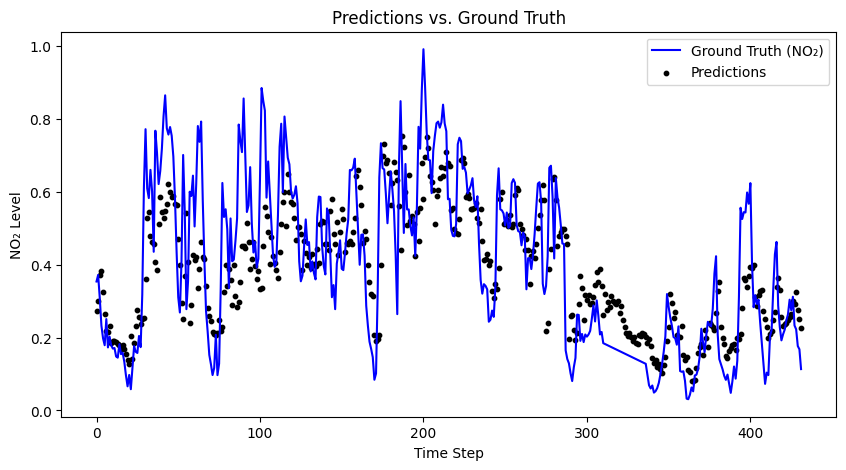

In [48]:
import torch
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
best_model_baseline.eval()

y_preds = []
y_trues = []

# Iterate through the test set and collect predictions & ground truth
with torch.no_grad():
    for batch in test_loader:
        x_test, y_true = batch  # Get input and ground truth
        x_test = x_test.to("cpu")  # Ensure data is on CPU if needed

        # Get predictions
        y_pred = best_model_baseline(x_test)

        # Store results
        y_preds.append(y_pred.cpu())
        y_trues.append(y_true.cpu())

# Convert lists to tensors
y_preds = torch.cat(y_preds, dim=0).numpy()
y_trues = torch.cat(y_trues, dim=0).numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(y_trues.flatten(), label="Ground Truth (NO₂)", linestyle="-", color="blue")
plt.scatter(range(len(y_preds.flatten())), y_preds.flatten(), label="Predictions", color="black", s=10)

plt.xlabel("Time Step")
plt.ylabel("NO₂ Level")
plt.title("Predictions vs. Ground Truth")
plt.legend()
#save the plot
plt.savefig(f"{RESULTS_PATH}/plots/{PLOT_FILENAME}")
plt.show()
